<a href="https://colab.research.google.com/github/Rusty-Thunderbird/NIFTY50_Options-Optimising-Strategy/blob/main/OptimisingOptionsStrategyBacktest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load and display the pickle file
import pickle

file_path = '/content/drive/MyDrive/Options_Data/INDIA_VIX.pickle'
with open(file_path, 'rb') as file:
    india_vix_data = pickle.load(file)

# Display the contents
print(india_vix_data)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                        Open     High      Low    Close   OI  Volume
TimeStamp                                                           
2022-08-05 12:29:00  18.8950  18.9025  18.8850  18.8925  0.0      40
2022-08-05 12:30:00  18.8950  18.9225  18.8825  18.9100  0.0      60
2022-08-05 12:31:00  18.9075  18.9225  18.9050  18.9100  0.0      60
2022-08-05 12:32:00  18.9100  18.9350  18.9075  18.9150  0.0      60
2022-08-05 12:33:00  18.9150  18.9250  18.9075  18.9175  0.0      60
...                      ...      ...      ...      ...  ...     ...
2025-05-27 15:25:00  18.4300  18.4425  18.4300  18.4425  0.0     120
2025-05-27 15:26:00  18.4425  18.4500  18.4175  18.4300  0.0     120
2025-05-27 15:27:00  18.4300  18.4575  18.4300  18.4550  0.0     120
2025-05-27 15:28:00  18.4575  18.4575  18.4225  18.4375  0.0     120
2025-05-27 15:29:00  18.4425  18.4775  18.4

/tmp/ipython-input-2-3895117582.py:10: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  india_vix_data = pickle.load(file)


In [ ]:
import pandas as pd
import pickle

# Load and display the pickle file
file_path = '/content/drive/MyDrive/Options_Data/INDIA_VIX.pickle'
with open(file_path, 'rb') as file:
    india_vix_data = pickle.load(file)

# Assuming the pickle file contains data that can be converted to a DataFrame
# Convert the loaded data to a pandas DataFrame
# You might need to adjust this based on the actual structure of your pickle data
df = pd.DataFrame(india_vix_data)

# If 'TimeStamp' is a column and you want to set it as the index
if 'TimeStamp' in df.columns:
    df.set_index('TimeStamp', inplace=True)
    # Ensure the index is in datetime format for date-based slicing
    df.index = pd.to_datetime(df.index)


start_date = '2025-01-01'
end_date = '2025-05-27'
# Filter the DataFrame using .loc with the date range
filtered_df = df.loc[start_date:end_date]

# Save to CSV
filtered_df.to_csv('filtered_data_2025_01_01_to_2025_05_27.csv')

print("Data saved to 'filtered_data_2025_01_01_to_2025_05_27.csv'")

/tmp/ipython-input-4-856897870.py:7: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  india_vix_data = pickle.load(file)


Data saved to 'filtered_data_2025_01_01_to_2025_05_27.csv'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================================
# CONFIGURATION
# ======================================================================
start_date = '2025-01-01'
end_date = '2025-02-07'
initial_capital = 1_000_000
lot_size = 50
risk_per_trade = 0.1
TP_PCT = 0.3
SL_PCT = 0.2
BROKERAGE_PER_ORDER = 20
SLIPPAGE_PCT = 0.001
SPREAD_WIDTH = 100  # points between strikes in the spread
VIX_RANK_WINDOW = 30 * 390  # 30 trading days of 390 min each

VIX_PATH = '/content/drive/MyDrive/Options_Data/Filtered_VIX_Jan_May_2025_1min.csv'

# ======================================================================
# DATA LOADING
# ======================================================================
def load_spot():
    df = pd.read_csv('/content/drive/MyDrive/Options_Data/NIFTY_50_minute_data_Jan_Feb_2025.csv', parse_dates=['date'])
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index).tz_localize('Asia/Kolkata')
    df = df.loc[start_date:end_date]
    return df

def load_signals():
    signals_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_signal_details.csv'
    signals = pd.read_csv(signals_path, parse_dates=['TimeStamp'])
    signals = signals.set_index('TimeStamp')
    if signals.index.tz is None:
        signals.index = pd.to_datetime(signals.index).tz_localize('Asia/Kolkata')
    else:
        signals.index = signals.index.tz_convert('Asia/Kolkata')
    return signals

def load_options_sample():
    sample_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_options_sample_ALL_EXPIRIES.csv'
    options_sample = pd.read_csv(sample_path)
    options_sample['TimeStamp'] = pd.to_datetime(options_sample['TimeStamp'])
    if options_sample['TimeStamp'].dt.tz is None:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_localize('Asia/Kolkata')
    else:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_convert('Asia/Kolkata')
    options_sample['Expiry'] = pd.to_datetime(options_sample['Expiry'])
    return options_sample

def load_vix():
    vix = pd.read_csv(VIX_PATH, parse_dates=['TimeStamp'])
    vix = vix.set_index('TimeStamp')
    if vix.index.tz is None:
        vix.index = pd.to_datetime(vix.index).tz_localize('Asia/Kolkata')
    else:
        vix.index = vix.index.tz_convert('Asia/Kolkata')
    vix = vix.rename(columns={'Close': 'VIX'})
    return vix

# ======================================================================
# UTILS
# ======================================================================
def get_nearest_strike(strikes, target):
    return min(strikes, key=lambda x: abs(x - target))

def get_nearest_expiry(expiry_list, ts):
    future_expiries = [e for e in expiry_list if e >= ts.date()]
    return min(future_expiries) if future_expiries else None

def calculate_vix_rank(vix_series, window=VIX_RANK_WINDOW):
    vix_min = vix_series.rolling(window=window, min_periods=1).min()
    vix_max = vix_series.rolling(window=window, min_periods=1).max()
    vix_rank = (vix_series - vix_min) / (vix_max - vix_min)
    vix_rank = vix_rank.fillna(0.5)
    return vix_rank

def in_trading_hours(ts):
    hour = ts.hour
    minute = ts.minute
    if (hour == 9 and minute >= 30) or (10 <= hour < 14) or (hour == 14 and minute <= 35):
        return True
    return False

# ======================================================================
# STRATEGY LOGIC
# ======================================================================
def execute_trades_mixed(
    spot_data, signals, options_data, vix_rank, tp_pct=TP_PCT, sl_pct=SL_PCT,
    brokerage_per_order=BROKERAGE_PER_ORDER, slippage_pct=SLIPPAGE_PCT,
    risk_per_trade=risk_per_trade, spread_width=SPREAD_WIDTH
):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_min = signals.reindex(spot_data.index, method='ffill').dropna()
    vix_rank = vix_rank.reindex(spot_data.index, method='ffill')
    open_position = None

    for ts, row in spot_data.iterrows():
        if ts not in signals_min.index or pd.isna(row['close']):
            continue
        if not in_trading_hours(ts):
            continue
        signal = signals_min.loc[ts, 'Signal']
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        expiry = get_nearest_expiry(expiry_list, ts)
        if expiry is None:
            continue
        vix_r = vix_rank.loc[ts] if ts in vix_rank.index else 0.5

        # --- BUY SIDE: as before ---
        if open_position is None and signal != 0:
            if signal == 1:
                # Buy CE (bullish)
                strike = get_nearest_strike(available_strikes, atm_strike)
                option_type = 'CE'
            else:
                # Buy PE (bearish)
                strike = get_nearest_strike(available_strikes, atm_strike)
                option_type = 'PE'
            entry_row = options_data[
                (options_data['Strike'] == strike) &
                (options_data['Type'] == option_type) &
                (options_data['Expiry'].dt.date == expiry) &
                (options_data['TimeStamp'] >= ts)
            ].sort_values('TimeStamp')
            if not entry_row.empty:
                entry_price = float(entry_row.iloc[0]['Close'])
                entry_time = entry_row.iloc[0]['TimeStamp']
                lots = int((portfolio_cash * risk_per_trade) // (entry_price * lot_size))
                if lots >= 1:
                    tp_price = entry_price * (1 + tp_pct)
                    sl_price = entry_price * (1 - sl_pct)
                    entry_slippage = entry_price * slippage_pct * lot_size * lots
                    total_slippage += entry_slippage
                    total_brokerage += brokerage_per_order
                    entry_price_adj = entry_price + entry_price * slippage_pct
                    open_position = {
                        'side': 'buy',
                        'entry_date': ts,
                        'entry_time': entry_time,
                        'action': 'Buy',
                        'type': option_type,
                        'strike': strike,
                        'entry_price': entry_price_adj,
                        'lots': lots,
                        'spot': spot_price,
                        'expiry': expiry,
                        'signal': signal,
                        'tp_price': tp_price,
                        'sl_price': sl_price,
                        'entry_slippage': entry_slippage
                    }
                    continue

        # --- SELL SIDE: Credit Spread (only if VIX rank >= 0.5) ---
        if open_position is None and signal != 0 and vix_r >= 0.5:
            if signal == 1:
                # Bullish: Put Credit Spread (Sell ATM PE, Buy lower PE)
                short_strike = get_nearest_strike(available_strikes, atm_strike)
                long_strike = get_nearest_strike(available_strikes, atm_strike - spread_width)
                short_type, long_type = 'PE', 'PE'
            else:
                # Bearish: Call Credit Spread (Sell ATM CE, Buy higher CE)
                short_strike = get_nearest_strike(available_strikes, atm_strike)
                long_strike = get_nearest_strike(available_strikes, atm_strike + spread_width)
                short_type, long_type = 'CE', 'CE'
            # Find premiums
            short_row = options_data[
                (options_data['Strike'] == short_strike) &
                (options_data['Type'] == short_type) &
                (options_data['Expiry'].dt.date == expiry) &
                (options_data['TimeStamp'] >= ts)
            ].sort_values('TimeStamp')
            long_row = options_data[
                (options_data['Strike'] == long_strike) &
                (options_data['Type'] == long_type) &
                (options_data['Expiry'].dt.date == expiry) &
                (options_data['TimeStamp'] >= ts)
            ].sort_values('TimeStamp')
            if not short_row.empty and not long_row.empty:
                short_price = float(short_row.iloc[0]['Close'])
                long_price = float(long_row.iloc[0]['Close'])
                entry_time = short_row.iloc[0]['TimeStamp']
                net_credit = (short_price - long_price)
                max_loss = spread_width - net_credit
                margin_required = max_loss * lot_size
                lots = int((portfolio_cash * risk_per_trade) // margin_required)
                if lots >= 1 and net_credit > 0:
                    entry_slippage = (short_price + long_price) * slippage_pct * lot_size * lots
                    total_slippage += entry_slippage
                    total_brokerage += 2 * brokerage_per_order  # sell + buy
                    net_credit_adj = (short_price - long_price) - (short_price + long_price) * slippage_pct
                    open_position = {
                        'side': 'sell',
                        'entry_date': ts,
                        'entry_time': entry_time,
                        'action': 'Sell',
                        'short_type': short_type,
                        'long_type': long_type,
                        'short_strike': short_strike,
                        'long_strike': long_strike,
                        'short_price': short_price,
                        'long_price': long_price,
                        'net_credit': net_credit_adj,
                        'lots': lots,
                        'spot': spot_price,
                        'expiry': expiry,
                        'signal': signal,
                        'spread_width': spread_width,
                        'max_loss': max_loss,
                        'entry_slippage': entry_slippage
                    }
                    continue

        # --- EXIT LOGIC (for both sides) ---
        if open_position is not None:
            # BUY SIDE EXIT
            if open_position['side'] == 'buy':
                option_rows = options_data[
                    (options_data['Strike'] == open_position['strike']) &
                    (options_data['Type'] == open_position['type']) &
                    (options_data['Expiry'].dt.date == open_position['expiry']) &
                    (options_data['TimeStamp'] >= open_position['entry_time']) &
                    (options_data['TimeStamp'] <= ts)
                ].sort_values('TimeStamp')
                exit_reason = None
                exit_price = None
                exit_time = None
                for _, opt_row in option_rows.iterrows():
                    if opt_row['High'] >= open_position['tp_price']:
                        exit_price = open_position['tp_price']
                        exit_time = opt_row['TimeStamp']
                        exit_reason = 'Take Profit'
                        break
                    elif opt_row['Low'] <= open_position['sl_price']:
                        exit_price = open_position['sl_price']
                        exit_time = opt_row['TimeStamp']
                        exit_reason = 'Stop Loss'
                        break
                if exit_reason is None and ts.date() >= open_position['expiry']:
                    last_row = option_rows.iloc[-1] if not option_rows.empty else None
                    if last_row is not None:
                        exit_price = float(last_row['Close'])
                        exit_time = last_row['TimeStamp']
                        exit_reason = 'Expiry'
                if exit_reason is not None and exit_price is not None:
                    exit_slippage = exit_price * slippage_pct * lot_size * open_position['lots']
                    total_slippage += exit_slippage
                    total_brokerage += brokerage_per_order
                    exit_price_adj = exit_price - exit_price * slippage_pct
                    holding_days = (exit_time - open_position['entry_date']).days
                    pnl = (exit_price_adj - open_position['entry_price']) * lot_size * open_position['lots']
                    pnl -= (open_position['entry_slippage'] + exit_slippage + 2 * brokerage_per_order)
                    portfolio_cash += pnl
                    trade_log.append({
                        'side': 'buy',
                        'entry_date': open_position['entry_date'],
                        'entry_time': open_position['entry_time'],
                        'exit_date': exit_time,
                        'action': open_position['action'],
                        'type': open_position['type'],
                        'strike': open_position['strike'],
                        'entry_price': open_position['entry_price'],
                        'exit_price': exit_price_adj,
                        'lots': open_position['lots'],
                        'pnl': pnl,
                        'holding_days': holding_days,
                        'spot': open_position['spot'],
                        'expiry': open_position['expiry'],
                        'exit_reason': exit_reason
                    })
                    open_position = None
            # SELL SIDE EXIT (credit spread)
            elif open_position['side'] == 'sell':
                short_rows = options_data[
                    (options_data['Strike'] == open_position['short_strike']) &
                    (options_data['Type'] == open_position['short_type']) &
                    (options_data['Expiry'].dt.date == open_position['expiry']) &
                    (options_data['TimeStamp'] >= open_position['entry_time']) &
                    (options_data['TimeStamp'] <= ts)
                ].sort_values('TimeStamp')
                long_rows = options_data[
                    (options_data['Strike'] == open_position['long_strike']) &
                    (options_data['Type'] == open_position['long_type']) &
                    (options_data['Expiry'].dt.date == open_position['expiry']) &
                    (options_data['TimeStamp'] >= open_position['entry_time']) &
                    (options_data['TimeStamp'] <= ts)
                ].sort_values('TimeStamp')
                exit_reason = None
                exit_short = None
                exit_long = None
                exit_time = None
                for ((_, short_row), (_, long_row)) in zip(short_rows.iterrows(), long_rows.iterrows()):
                    # Stop loss: if loss exceeds 1.5x net credit
                    spread_now = (short_row['Close'] - long_row['Close'])
                    loss_now = open_position['net_credit'] - spread_now
                    if loss_now < -1.5 * open_position['net_credit']:
                        exit_short = short_row['Close']
                        exit_long = long_row['Close']
                        exit_time = short_row['TimeStamp']
                        exit_reason = 'Stop Loss'
                        break
                    # Take profit: if gain exceeds 80% of net credit
                    if spread_now < 0.2 * open_position['net_credit']:
                        exit_short = short_row['Close']
                        exit_long = long_row['Close']
                        exit_time = short_row['TimeStamp']
                        exit_reason = 'Take Profit'
                        break
                if exit_reason is None and ts.date() >= open_position['expiry']:
                    # On expiry, calculate intrinsic value
                    short_iv = max(0, (spot_price - open_position['short_strike']) if open_position['short_type'] == 'CE' else (open_position['short_strike'] - spot_price))
                    long_iv = max(0, (spot_price - open_position['long_strike']) if open_position['long_type'] == 'CE' else (open_position['long_strike'] - spot_price))
                    exit_short = short_iv
                    exit_long = long_iv
                    exit_time = ts
                    exit_reason = 'Expiry'
                if exit_reason is not None and exit_short is not None and exit_long is not None:
                    exit_slippage = (exit_short + exit_long) * slippage_pct * lot_size * open_position['lots']
                    total_slippage += exit_slippage
                    total_brokerage += 2 * brokerage_per_order
                    net_exit = (exit_short - exit_long) - (exit_short + exit_long) * slippage_pct
                    holding_days = (exit_time - open_position['entry_date']).days
                    pnl = (open_position['net_credit'] - net_exit) * lot_size * open_position['lots']
                    pnl -= (open_position['entry_slippage'] + exit_slippage + 4 * brokerage_per_order)
                    portfolio_cash += pnl
                    trade_log.append({
                        'side': 'sell',
                        'entry_date': open_position['entry_date'],
                        'entry_time': open_position['entry_time'],
                        'exit_date': exit_time,
                        'action': open_position['action'],
                        'short_type': open_position['short_type'],
                        'long_type': open_position['long_type'],
                        'short_strike': open_position['short_strike'],
                        'long_strike': open_position['long_strike'],
                        'entry_net_credit': open_position['net_credit'],
                        'exit_net_debit': net_exit,
                        'lots': open_position['lots'],
                        'pnl': pnl,
                        'holding_days': holding_days,
                        'spot': open_position['spot'],
                        'expiry': open_position['expiry'],
                        'exit_reason': exit_reason
                    })
                    open_position = None
    return trade_log, total_brokerage, total_slippage

# ======================================================================
# EXECUTION FLOW
# ======================================================================
print("Loading spot data...")
spot_data = load_spot()
print(f"Spot data shape: {spot_data.shape}")

print("\nLoading signals...")
signals = load_signals()
print(f"Signals shape: {signals.shape}")

print("\nLoading options sample...")
options_sample = load_options_sample()
print("\nOptions sample loaded.")

print("\nLoading VIX data...")
vix = load_vix()
vix_rank = calculate_vix_rank(vix['VIX'])
print("VIX data loaded.")

print("\nExecuting trades minute by minute (buy and sell/credit spreads, VIX filter)...")
trade_log, total_brokerage, total_slippage = execute_trades_mixed(
    spot_data, signals, options_sample, vix_rank
)
trade_log_df = pd.DataFrame(trade_log)
if not trade_log_df.empty:
    trade_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_detailed_trade_log_minute_mixed_ALL_EXPIRIES.csv', index=False)
    print("\nDetailed trade log saved to Jan_Feb_detailed_trade_log_minute_mixed_ALL_EXPIRIES.csv")
    print(trade_log_df.head(10))
else:
    print("No trades executed.")

# ======================================================================
# STRATEGY PERFORMANCE REPORT AND VISUALIZATIONS (as before)
# ======================================================================
if not trade_log_df.empty:
    # ... (performance reporting and visualizations as in your previous code)
    pass
else:
    print("No trades to report.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading spot data...
Spot data shape: (10875, 5)

Loading 1-min signals...
Signals shape: (53655, 1)

Loading options sample...

Options sample loaded.

Executing trades 1-minutely with crossover, take profit, stop loss, brokerage, and slippage...

Detailed trade log saved to Jan_Feb_detailed_trade_log_1min_crossover_tp_sl_ALL_EXPIRIES.csv
                 entry_date                entry_time  \
0 2025-01-01 09:15:00+05:30 2025-01-01 09:15:00+05:30   
1 2025-01-01 11:29:00+05:30 2025-01-01 11:29:00+05:30   
2 2025-01-01 11:34:00+05:30 2025-01-01 11:34:00+05:30   
3 2025-01-01 11:57:00+05:30 2025-01-01 11:57:00+05:30   
4 2025-01-01 12:02:00+05:30 2025-01-01 12:02:00+05:30   
5 2025-01-01 12:42:00+05:30 2025-01-01 12:42:00+05:30   
6 2025-01-01 12:52:00+05:30 2025-01-01 12:52:00+05:30   
7 2025-01-01 12:56:00+05:30 2025-01-01 12:56:00+05:30   
8 2025-01-01 12:

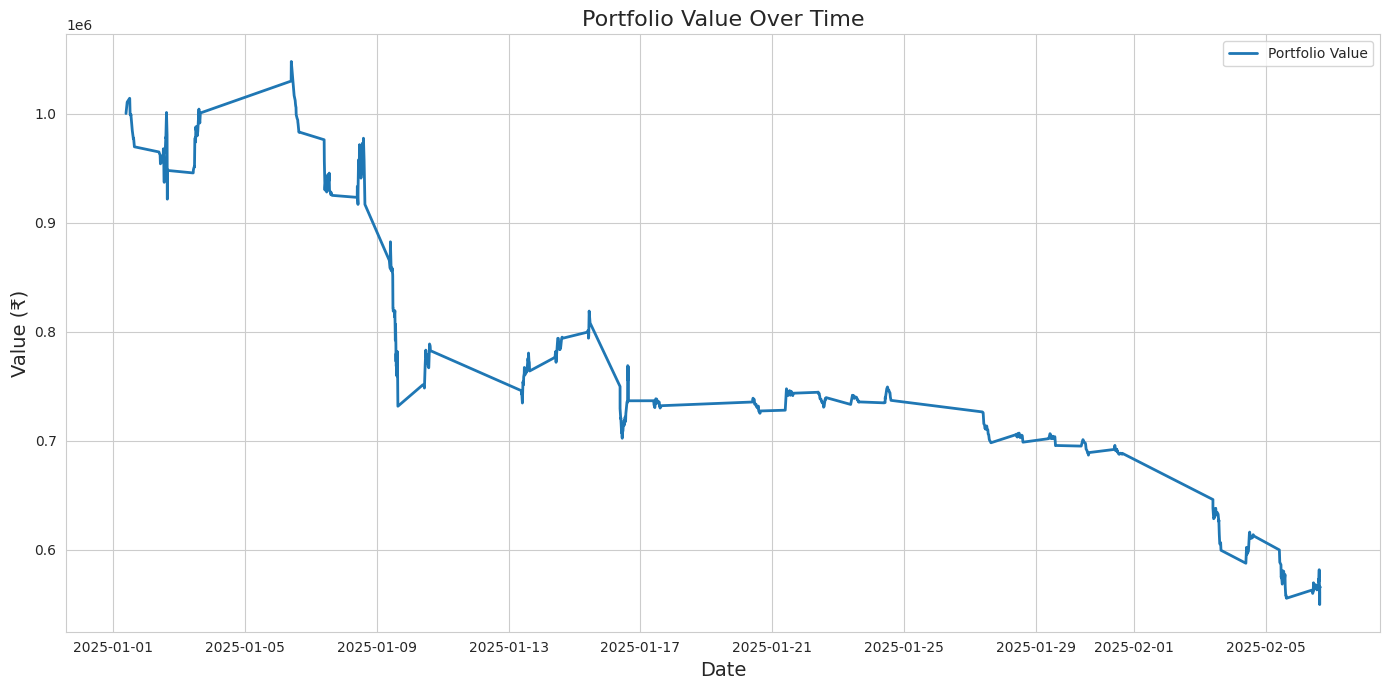

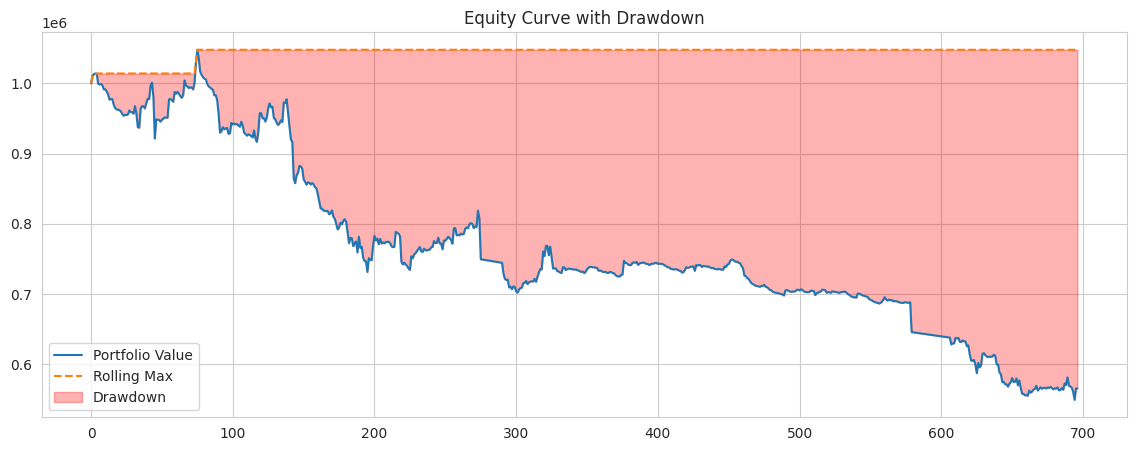

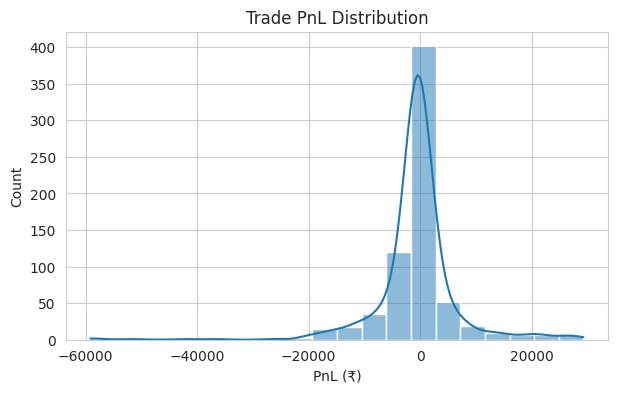

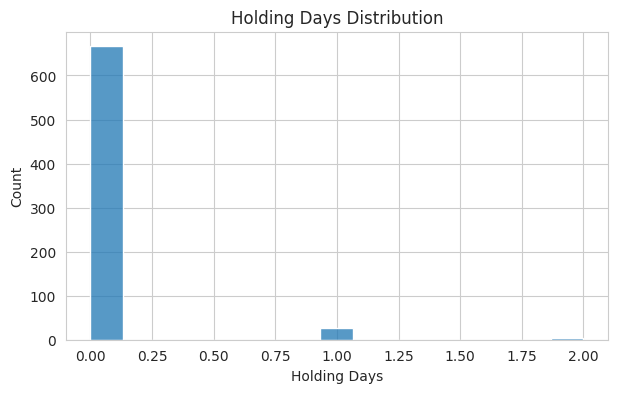

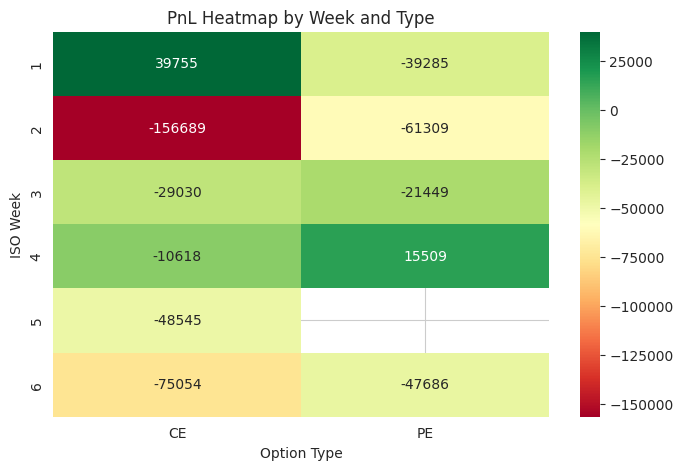

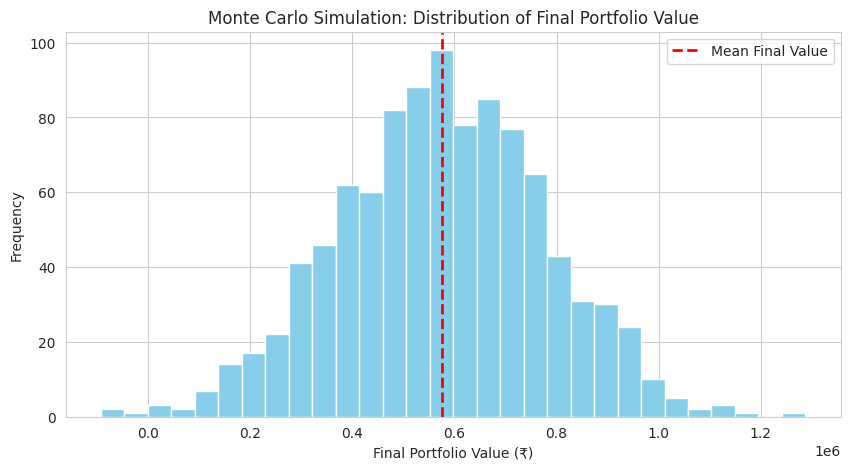

Monte Carlo: Mean Final Value = ₹575,457.22, 5th Percentile = ₹243,359.02, 95th Percentile = ₹916,471.56


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================================
# CONFIGURATION
# ======================================================================
start_date = '2025-01-01'
end_date = '2025-02-07'
initial_capital = 1_000_000
lot_size = 50
risk_per_trade = 0.1  # 10% per trade
TP_PCT = 0.3  # 30% take profit (relative to entry price)
SL_PCT = 0.2  # 20% stop loss (relative to entry price)
BROKERAGE_PER_ORDER = 20  # INR per order (entry and exit)
SLIPPAGE_PCT = 0.001  # 0.1% per side

# ======================================================================
# DATA LOADING
# ======================================================================
def load_spot():
    df = pd.read_csv('/content/drive/MyDrive/Options_Data/NIFTY_50_minute_data_Jan_Feb_2025.csv', parse_dates=['date'])
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index).tz_localize('Asia/Kolkata')
    df = df.loc[start_date:end_date]
    return df

def load_signals_1min():
    signals_path = '/content/drive/MyDrive/Options_Data/Nifty_50_signals_1min.csv'
    signals = pd.read_csv(signals_path, parse_dates=['date'])
    signals = signals.set_index('date')
    if signals.index.tz is None:
        signals.index = pd.to_datetime(signals.index).tz_localize('Asia/Kolkata')
    else:
        signals.index = signals.index.tz_convert('Asia/Kolkata')
    if 'Signal' not in signals.columns:
        signals.columns = ['Signal']
    return signals

def load_options_sample():
    sample_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_options_sample_ALL_EXPIRIES.csv'
    options_sample = pd.read_csv(sample_path)
    options_sample['TimeStamp'] = pd.to_datetime(options_sample['TimeStamp'])
    if options_sample['TimeStamp'].dt.tz is None:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_localize('Asia/Kolkata')
    else:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_convert('Asia/Kolkata')
    options_sample['Expiry'] = pd.to_datetime(options_sample['Expiry'])
    return options_sample

# ======================================================================
# STRATEGY LOGIC
# ======================================================================
def get_nearest_strike(strikes, target):
    return min(strikes, key=lambda x: abs(x - target))

def get_nearest_expiry(expiry_list, ts):
    future_expiries = [e for e in expiry_list if e >= ts.date()]
    return min(future_expiries) if future_expiries else None

def execute_trades_1min_crossover_tp_sl(
    spot_data, signals, options_data, tp_pct=TP_PCT, sl_pct=SL_PCT,
    brokerage_per_order=BROKERAGE_PER_ORDER, slippage_pct=SLIPPAGE_PCT
):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_1min = signals.reindex(spot_data.index, method='ffill').dropna()
    open_position = None
    prev_signal = 0

    for ts, row in spot_data.iterrows():
        if ts not in signals_1min.index or pd.isna(row['close']):
            continue
        signal = signals_1min.loc[ts, 'Signal']
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        strike = get_nearest_strike(available_strikes, atm_strike)
        option_type = 'CE' if signal == 1 else 'PE'
        expiry = get_nearest_expiry(expiry_list, ts)
        if expiry is None:
            prev_signal = signal
            continue

        # ENTRY: Only when signal changes from prev_signal to new signal (crossover)
        if open_position is None and signal != 0 and signal != prev_signal:
            entry_row = options_data[
                (options_data['Strike'] == strike) &
                (options_data['Type'] == option_type) &
                (options_data['Expiry'].dt.date == expiry) &
                (options_data['TimeStamp'] >= ts)
            ].sort_values('TimeStamp')
            if entry_row.empty:
                prev_signal = signal
                continue
            entry_price = float(entry_row.iloc[0]['Close'])
            entry_time = entry_row.iloc[0]['TimeStamp']
            lots = int((portfolio_cash * risk_per_trade) // (entry_price * lot_size))
            if lots < 1:
                prev_signal = signal
                continue
            tp_price = entry_price * (1 + tp_pct)
            sl_price = entry_price * (1 - sl_pct)
            entry_slippage = entry_price * slippage_pct * lot_size * lots
            total_slippage += entry_slippage
            total_brokerage += brokerage_per_order
            entry_price_adj = entry_price + entry_price * slippage_pct  # Buy at ask
            open_position = {
                'entry_date': ts,
                'entry_time': entry_time,
                'action': 'Buy',
                'type': option_type,
                'strike': strike,
                'entry_price': entry_price_adj,
                'lots': lots,
                'spot': spot_price,
                'expiry': expiry,
                'signal': signal,
                'tp_price': tp_price,
                'sl_price': sl_price,
                'entry_slippage': entry_slippage
            }
            prev_signal = signal
            continue

        # EXIT: On signal reversal (crossover in opposite direction), TP, SL, or expiry
        if open_position is not None:
            exit_reason = None
            exit_price = None
            exit_time = None

            # 1. Signal reversal
            if signal != open_position['signal']:
                exit_reason = 'Signal Reversal'
                exit_row = options_data[
                    (options_data['Strike'] == open_position['strike']) &
                    (options_data['Type'] == open_position['type']) &
                    (options_data['Expiry'].dt.date == open_position['expiry']) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                if not exit_row.empty:
                    exit_price = float(exit_row.iloc[0]['Close'])
                    exit_time = exit_row.iloc[0]['TimeStamp']
            else:
                # 2. TP/SL
                option_rows = options_data[
                    (options_data['Strike'] == open_position['strike']) &
                    (options_data['Type'] == open_position['type']) &
                    (options_data['Expiry'].dt.date == open_position['expiry']) &
                    (options_data['TimeStamp'] >= open_position['entry_time']) &
                    (options_data['TimeStamp'] <= ts)
                ].sort_values('TimeStamp')

                for _, opt_row in option_rows.iterrows():
                    if opt_row['High'] >= open_position['tp_price']:
                        exit_price = open_position['tp_price']
                        exit_time = opt_row['TimeStamp']
                        exit_reason = 'Take Profit'
                        break
                    elif opt_row['Low'] <= open_position['sl_price']:
                        exit_price = open_position['sl_price']
                        exit_time = opt_row['TimeStamp']
                        exit_reason = 'Stop Loss'
                        break

                # 3. Expiry
                if exit_reason is None and ts.date() >= open_position['expiry']:
                    last_row = option_rows.iloc[-1] if not option_rows.empty else None
                    if last_row is not None:
                        exit_price = float(last_row['Close'])
                        exit_time = last_row['TimeStamp']
                        exit_reason = 'Expiry'

            if exit_reason is not None and exit_price is not None:
                exit_slippage = exit_price * slippage_pct * lot_size * open_position['lots']
                total_slippage += exit_slippage
                total_brokerage += brokerage_per_order
                exit_price_adj = exit_price - exit_price * slippage_pct  # Sell at bid
                holding_days = (exit_time - open_position['entry_date']).days if exit_time and open_position['entry_date'] else 0
                pnl = (exit_price_adj - open_position['entry_price']) * lot_size * open_position['lots']
                pnl -= (open_position['entry_slippage'] + exit_slippage + 2 * brokerage_per_order)
                portfolio_cash += pnl
                trade_log.append({
                    'entry_date': open_position['entry_date'],
                    'entry_time': open_position['entry_time'],
                    'exit_date': exit_time,
                    'action': open_position['action'],
                    'type': open_position['type'],
                    'strike': open_position['strike'],
                    'entry_price': open_position['entry_price'],
                    'exit_price': exit_price_adj,
                    'lots': open_position['lots'],
                    'pnl': pnl,
                    'holding_days': holding_days,
                    'spot': open_position['spot'],
                    'expiry': open_position['expiry'],
                    'exit_reason': exit_reason
                })
                open_position = None

        prev_signal = signal

    return trade_log, total_brokerage, total_slippage

# ======================================================================
# EXECUTION FLOW
# ======================================================================
print("Loading spot data...")
spot_data = load_spot()
print(f"Spot data shape: {spot_data.shape}")

print("\nLoading 1-min signals...")
signals = load_signals_1min()
print(f"Signals shape: {signals.shape}")

print("\nLoading options sample...")
options_sample = load_options_sample()
print("\nOptions sample loaded.")

print("\nExecuting trades 1-minutely with crossover, take profit, stop loss, brokerage, and slippage...")
trade_log, total_brokerage, total_slippage = execute_trades_1min_crossover_tp_sl(
    spot_data, signals, options_sample
)
trade_log_df = pd.DataFrame(trade_log)
if not trade_log_df.empty:
    trade_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_detailed_trade_log_1min_crossover_tp_sl_ALL_EXPIRIES.csv', index=False)
    print("\nDetailed trade log saved to Jan_Feb_detailed_trade_log_1min_crossover_tp_sl_ALL_EXPIRIES.csv")
    print(trade_log_df.head(10))
else:
    print("No trades executed.")

# ======================================================================
# STRATEGY PERFORMANCE REPORT AND VISUALIZATIONS
# ======================================================================
if not trade_log_df.empty:
    # Portfolio value over time
    portfolio_values = [initial_capital]
    portfolio_dates = [trade_log_df['entry_date'].iloc[0]]
    current_value = initial_capital
    for i, row in trade_log_df.iterrows():
        current_value += row['pnl']
        portfolio_values.append(current_value)
        portfolio_dates.append(row['exit_date'])
    returns = pd.Series(portfolio_values).pct_change().dropna()
    rf = 0.01  # risk-free rate (annual)
    sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    downside_std = returns[returns < 0].std()
    sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
    cumulative = pd.Series(portfolio_values)
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = abs(drawdown.min()) * initial_capital
    years = len(portfolio_values) / 252
    cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
    calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

    print(f"""
Strategy Performance Report:
-----------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
Total Brokerage:    ₹{total_brokerage:,.2f}
Total Slippage:     ₹{total_slippage:,.2f}

Trade Statistics:
-----------------
Total Trades:       {len(trade_log_df)}
Winning Trades:     {(trade_log_df['pnl'] > 0).sum()}
Losing Trades:      {(trade_log_df['pnl'] <= 0).sum()}
Avg PnL:            ₹{trade_log_df['pnl'].mean():,.2f}
Best Trade:         ₹{trade_log_df['pnl'].max():,.2f}
Worst Trade:        ₹{trade_log_df['pnl'].min():,.2f}
Trade Period:       {trade_log_df['entry_date'].min().date()} to {trade_log_df['exit_date'].max().date()}
""")

    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_dates, portfolio_values, label='Portfolio Value', linewidth=2)
    plt.title('Portfolio Value Over Time', fontsize=16)
    plt.ylabel('Value (₹)', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.plot(cumulative, label='Portfolio Value')
    plt.plot(rolling_max, '--', label='Rolling Max')
    plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
    plt.title("Equity Curve with Drawdown")
    plt.legend()
    plt.show()

    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['pnl'], bins=20, kde=True)
    plt.title("Trade PnL Distribution")
    plt.xlabel("PnL (₹)")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(7, 4))
    sns.histplot(trade_log_df['holding_days'], bins=15, kde=False)
    plt.title("Holding Days Distribution")
    plt.xlabel("Holding Days")
    plt.ylabel("Count")
    plt.show()

    trade_log_df['exit_week'] = pd.to_datetime(trade_log_df['exit_date']).dt.isocalendar().week
    heatmap_data = trade_log_df.pivot_table(index='exit_week', columns='type', values='pnl', aggfunc='sum')
    plt.figure(figsize=(8, 5))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='RdYlGn')
    plt.title("PnL Heatmap by Week and Type")
    plt.xlabel("Option Type")
    plt.ylabel("ISO Week")
    plt.show()

    n_sim = 1000
    sim_length = len(trade_log_df)
    sim_results = []
    for _ in range(n_sim):
        sim_pnls = np.random.choice(trade_log_df['pnl'], size=sim_length, replace=True)
        sim_curve = np.cumsum(np.insert(sim_pnls, 0, initial_capital))
        sim_results.append(sim_curve[-1])
    plt.figure(figsize=(10, 5))
    plt.hist(sim_results, bins=30, color='skyblue')
    plt.axvline(np.mean(sim_results), color='red', linestyle='dashed', linewidth=2, label='Mean Final Value')
    plt.title("Monte Carlo Simulation: Distribution of Final Portfolio Value")
    plt.xlabel("Final Portfolio Value (₹)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    print(f"Monte Carlo: Mean Final Value = ₹{np.mean(sim_results):,.2f}, 5th Percentile = ₹{np.percentile(sim_results, 5):,.2f}, 95th Percentile = ₹{np.percentile(sim_results, 95):,.2f}")

else:
    print("No trades to report.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading spot data...
Spot data shape: (10875, 5)

Loading 15-min signals...
Signals shape: (3577, 1)

Loading options sample...
Options sample loaded.

Loading VIX data...
VIX data shape: (9891, 6)

Executing SELL-SIDE (CREDIT SPREAD) strategy...


/tmp/ipython-input-4-3230767726.py:168: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'], group_keys=False).apply(


Sell-side trade log saved.

Executing BUY-SIDE (OPTION BUYING) strategy...


/tmp/ipython-input-4-3230767726.py:338: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: compute_atr(x, BUY_ATR_PERIOD)).reset_index(level=[0,1,2], drop=True)


Buy-side trade log saved.

COMBINED STRATEGY PERFORMANCE REPORT
-------------------------------------
Initial Capital:    ₹1,000,000.00
Final Portfolio:    ₹1,833,000.80
Total Return:       83.30%
Max Drawdown:       ₹57,594.24
Sharpe Ratio:       3.36
Sortino Ratio:      13.70
Calmar Ratio:       27.73
Total Brokerage:    ₹4,760.00
Total Slippage:     ₹25,983.55

Trade Statistics:
-----------------
Total Trades:       159
Buy Trades:         141
Sell Trades:        18
Winning Trades:     100
Losing Trades:      59
Avg PnL:            ₹5,239.00
Best Trade:         ₹198,283.37
Worst Trade:        ₹-18,000.00
Trade Period:       2025-01-01 to 2025-02-06



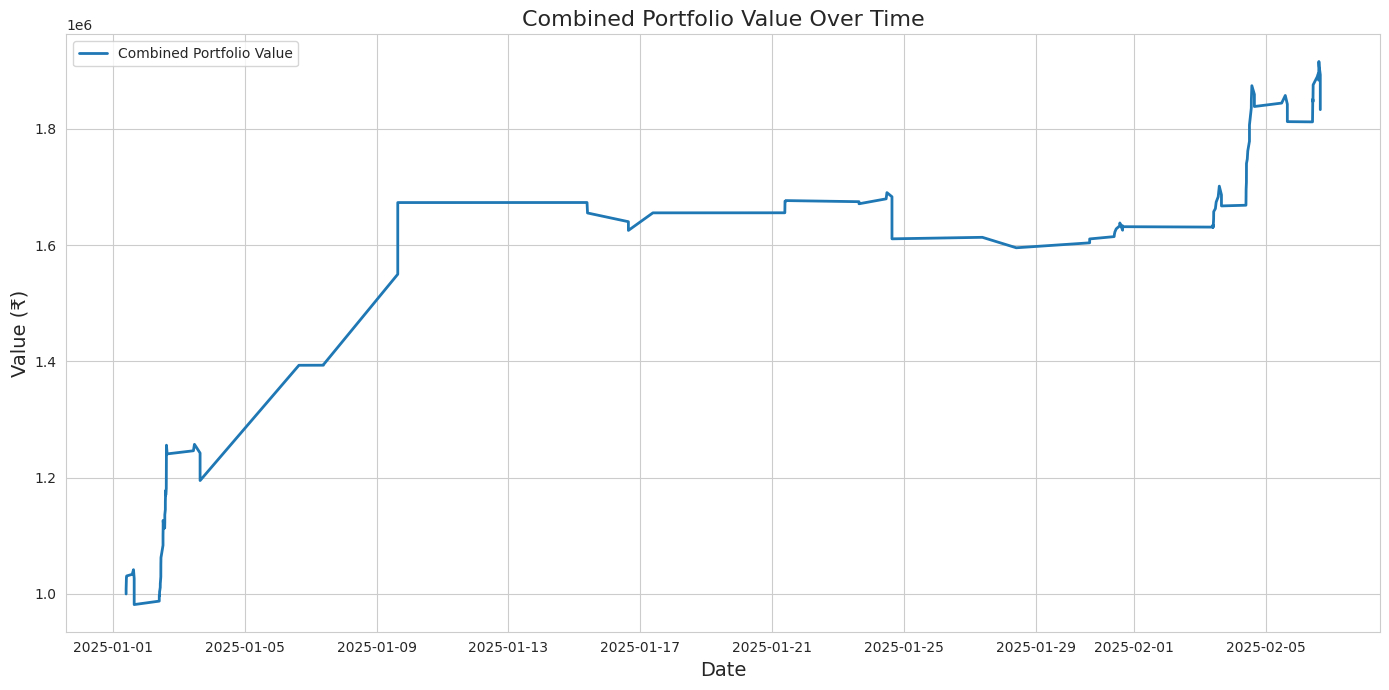

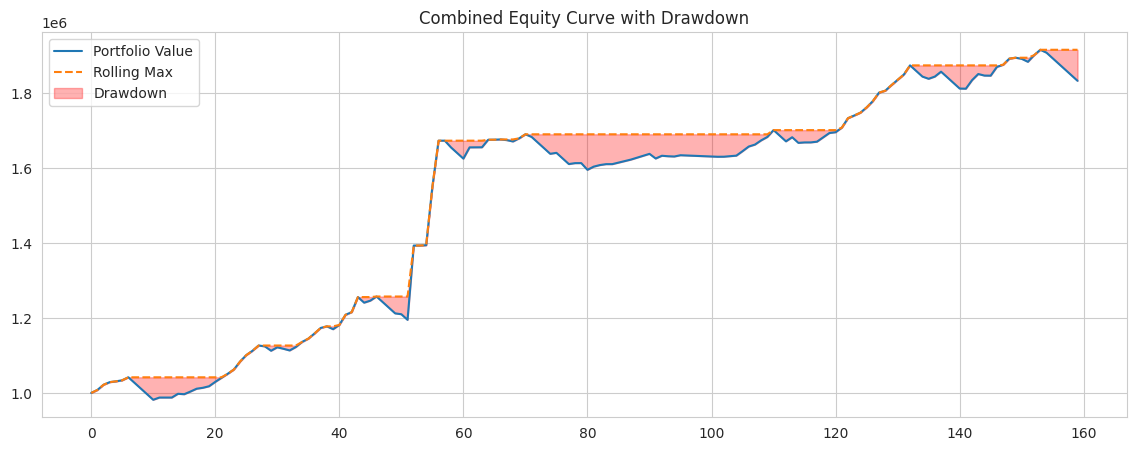

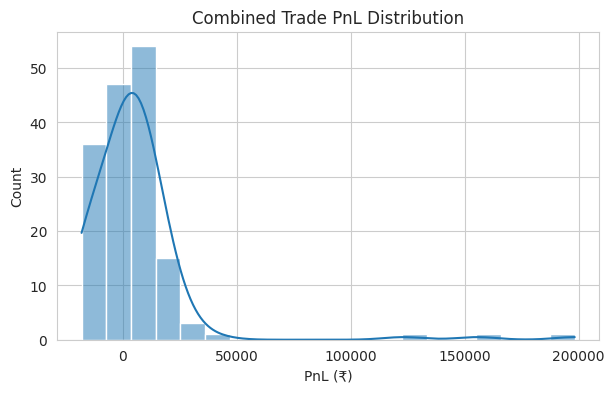

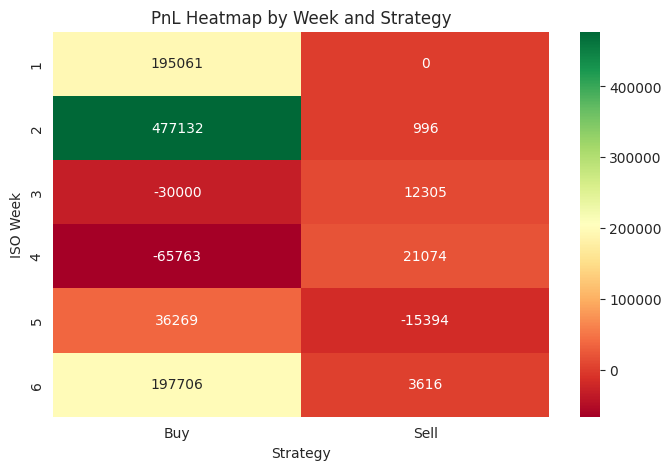

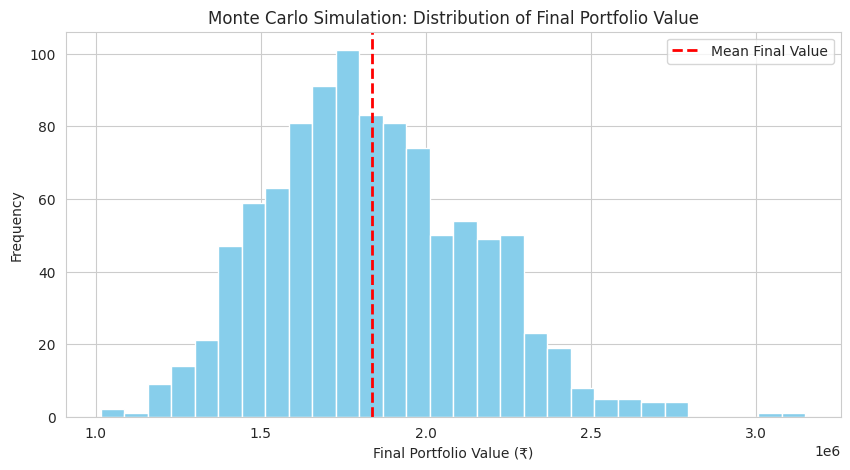

Monte Carlo: Mean Final Value = ₹1,836,615.78, 5th Percentile = ₹1,374,847.43, 95th Percentile = ₹2,355,087.35


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# CONFIGURATION
# ==============================
start_date = '2025-01-01'
end_date = '2025-02-07'
initial_capital = 1_000_000
lot_size = 50

# --- SELL-SIDE config ---
SELL_ATR_PERIOD = 10
SELL_ATR_MULTIPLIER = 2.5
SELL_BROKERAGE_PER_ORDER = 20
SELL_SLIPPAGE_PCT = 0.001
SELL_MARKET_CLOSE_TIME = '15:25:00'
SELL_VIX_LOW = 14
SELL_VIX_HIGH = 22
SELL_RISK_LOW = 0.15
SELL_RISK_MED = 0.10
SELL_RISK_HIGH = 0.05
SELL_CONFIRM_LOOKBACK = 10
SELL_MAX_LOSS = 18000
SELL_PARTIAL_BOOK_PCT = 0.2

# --- BUY-SIDE config ---
BUY_PARTIAL_TP_PCT = 0.15
BUY_FINAL_TP_PCT_LOW = 0.20
BUY_FINAL_TP_PCT_HIGH = 0.40
BUY_ATR_PERIOD = 10
BUY_ATR_MULTIPLIER = 2.5
BUY_MAX_LOSS = 15000
BUY_BROKERAGE_PER_ORDER = 20
BUY_SLIPPAGE_PCT = 0.001
BUY_MARKET_CLOSE_TIME = '15:25:00'
BUY_VIX_LOW = 13
BUY_VIX_MED = 17
BUY_RISK_LOW = 0.15
BUY_RISK_MED = 0.10
BUY_RISK_HIGH = 0.05
BUY_IVR_THRESHOLD = 40

# ==============================
# DATA LOADING (shared)
# ==============================
def load_spot():
    df = pd.read_csv('/content/drive/MyDrive/Options_Data/NIFTY_50_minute_data_Jan_Feb_2025.csv', parse_dates=['date'])
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index).tz_localize('Asia/Kolkata')
    df = df.loc[start_date:end_date]
    return df

def load_signals_15min():
    signals_path = '/content/drive/MyDrive/Options_Data/Nifty_50_signals_15min_50_200.csv'
    signals = pd.read_csv(signals_path, parse_dates=['date'])
    signals = signals.set_index('date')
    if signals.index.tz is None:
        signals.index = pd.to_datetime(signals.index).tz_localize('Asia/Kolkata')
    else:
        signals.index = signals.index.tz_convert('Asia/Kolkata')
    if 'Signal' not in signals.columns:
        signals.columns = ['Signal']
    return signals

def load_options_sample():
    sample_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_options_sample_ALL_EXPIRIES.csv'
    options_sample = pd.read_csv(sample_path)
    options_sample['TimeStamp'] = pd.to_datetime(options_sample['TimeStamp'])
    if options_sample['TimeStamp'].dt.tz is None:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_localize('Asia/Kolkata')
    else:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_convert('Asia/Kolkata')
    options_sample['Expiry'] = pd.to_datetime(options_sample['Expiry'])
    return options_sample

def load_vix():
    vix_path = '/content/drive/MyDrive/Options_Data/Filtered_VIX_Jan_May_2025_1min.csv'
    vix = pd.read_csv(vix_path, parse_dates=['TimeStamp'])
    vix = vix.set_index('TimeStamp')
    vix.index = pd.to_datetime(vix.index).tz_localize('Asia/Kolkata')
    vix = vix.loc[start_date:end_date]
    return vix

# ==============================
# SELL-SIDE STRATEGY HELPERS & LOGIC
# ==============================
def get_nearest_strike(strikes, target):
    return min(strikes, key=lambda x: abs(x - target))

def get_nearest_expiry(expiry_list, ts):
    future_expiries = [e for e in expiry_list if e >= ts.date()]
    return min(future_expiries) if future_expiries else None

def compute_atr(df, period=SELL_ATR_PERIOD):
    high = df['High']
    low = df['Low']
    close = df['Close']
    prev_close = close.shift(1)
    tr = pd.concat([high - low, (high - prev_close).abs(), (low - prev_close).abs()], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=1).mean()
    return atr

def get_risk_per_trade_sell(vix_value):
    if vix_value <= 14:
        return 0.20
    elif vix_value <= SELL_VIX_LOW:
        return SELL_RISK_LOW
    elif vix_value <= SELL_VIX_HIGH:
        return SELL_RISK_MED
    else:
        return SELL_RISK_HIGH

def vix_trend_filter(vix_val):
    return SELL_VIX_LOW < vix_val < SELL_VIX_HIGH

def price_breakout_confirmation(spot_data, ts, direction, lookback=SELL_CONFIRM_LOOKBACK, sma_period=21):
    window = spot_data.loc[:ts].iloc[-lookback:]
    if len(window) < lookback:
        return False
    last_close = window['close'].iloc[-1]
    mean_high = window['high'][:-1].mean()
    mean_low = window['low'][:-1].mean()
    sma21 = window['close'].rolling(window=sma_period, min_periods=1).mean().iloc[-1]
    if direction == 1:
        return last_close > mean_high and last_close > sma21
    elif direction == -1:
        return last_close < mean_low and last_close < sma21
    return False

def trend_filter(spot_data, ts, direction, sma_period=50):
    window = spot_data.loc[:ts].iloc[-sma_period:]
    if len(window) < sma_period:
        return False
    last_close = window['close'].iloc[-1]
    sma = window['close'].mean()
    if direction == 1:
        return last_close > sma
    elif direction == -1:
        return last_close < sma
    return False

def get_dynamic_tp(vix_val):
    if vix_val <= SELL_VIX_LOW + 1:
        return 0.15
    elif vix_val <= SELL_VIX_HIGH - 1:
        return 0.25
    else:
        return 0.35

def execute_sell_side(spot_data, signals, options_data, vix_data):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_15min = signals.reindex(spot_data.index, method='ffill').dropna()
    vix_data = vix_data.reindex(spot_data.index, method='ffill').dropna()
    open_spread = None
    prev_signal = 0
    options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'], group_keys=False).apply(
        lambda x: compute_atr(x[['High', 'Low', 'Close']], SELL_ATR_PERIOD)
    )
    for ts, row in spot_data.iterrows():
        if ts not in signals_15min.index or pd.isna(row['close']):
            continue
        signal = signals_15min.loc[ts, 'Signal']
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        expiry = get_nearest_expiry(expiry_list, ts)
        vix_val = vix_data.loc[ts, 'Close'] if ts in vix_data.index else None
        if expiry is None or vix_val is None or np.isnan(vix_val):
            prev_signal = signal
            continue
        risk_per_trade = get_risk_per_trade_sell(vix_val)
        if not vix_trend_filter(vix_val):
            prev_signal = signal
            continue
        if not trend_filter(spot_data, ts, signal, sma_period=50):
            prev_signal = signal
            continue
        if open_spread is None and signal != 0 and signal != prev_signal and price_breakout_confirmation(spot_data, ts, signal):
            if signal == 1:
                short_strike = atm_strike
                long_strike = atm_strike - 100
                short_leg = options_data[
                    (options_data['Strike'] == short_strike) &
                    (options_data['Type'] == 'PE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                long_leg = options_data[
                    (options_data['Strike'] == long_strike) &
                    (options_data['Type'] == 'PE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
            else:
                short_strike = atm_strike
                long_strike = atm_strike + 100
                short_leg = options_data[
                    (options_data['Strike'] == short_strike) &
                    (options_data['Type'] == 'CE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                long_leg = options_data[
                    (options_data['Strike'] == long_strike) &
                    (options_data['Type'] == 'CE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
            if short_leg.empty or long_leg.empty:
                prev_signal = signal
                continue
            short_price = float(short_leg.iloc[0]['Close'])
            long_price = float(long_leg.iloc[0]['Close'])
            credit = (short_price - long_price) * lot_size
            margin_per_lot = abs(short_strike - long_strike) * lot_size - credit
            lots = int((portfolio_cash * risk_per_trade) // margin_per_lot)
            if lots < 1:
                prev_signal = signal
                continue
            tp_pct = get_dynamic_tp(vix_val)
            open_spread = {
                'entry_date': ts,
                'short_leg': {'strike': short_strike, 'type': short_leg.iloc[0]['Type'], 'expiry': expiry, 'price': short_price},
                'long_leg': {'strike': long_strike, 'type': long_leg.iloc[0]['Type'], 'expiry': expiry, 'price': long_price},
                'credit': credit,
                'lots': lots,
                'direction': 'bull_put' if signal == 1 else 'bear_call',
                'risk_per_trade': risk_per_trade,
                'vix_at_entry': vix_val,
                'tp_pct': tp_pct,
                'partial_booked': False
            }
            prev_signal = signal
            continue
        if open_spread is not None:
            short_leg, long_leg = open_spread['short_leg'], open_spread['long_leg']
            spread_rows_short = options_data[
                (options_data['Strike'] == short_leg['strike']) &
                (options_data['Type'] == short_leg['type']) &
                (options_data['Expiry'].dt.date == short_leg['expiry']) &
                (options_data['TimeStamp'] >= open_spread['entry_date']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            spread_rows_long = options_data[
                (options_data['Strike'] == long_leg['strike']) &
                (options_data['Type'] == long_leg['type']) &
                (options_data['Expiry'].dt.date == long_leg['expiry']) &
                (options_data['TimeStamp'] >= open_spread['entry_date']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            for i in range(min(len(spread_rows_short), len(spread_rows_long))):
                short_price = float(spread_rows_short.iloc[i]['Close'])
                long_price = float(spread_rows_long.iloc[i]['Close'])
                spread_value = (short_price - long_price) * lot_size
                pnl = (open_spread['credit'] - spread_value) * open_spread['lots']
                tp_level = open_spread['credit'] * open_spread['tp_pct']
                if not open_spread['partial_booked'] and pnl > tp_level:
                    booked_pnl = tp_level * SELL_PARTIAL_BOOK_PCT
                    portfolio_cash += booked_pnl
                    open_spread['credit'] -= booked_pnl
                    open_spread['lots'] = int(open_spread['lots'] * (1 - SELL_PARTIAL_BOOK_PCT))
                    open_spread['partial_booked'] = True
                    trade_log.append({**open_spread, 'exit_date': spread_rows_short.iloc[i]['TimeStamp'], 'exit_pnl': booked_pnl, 'exit_reason': 'Partial TP'})
                elif pnl > tp_level and open_spread['partial_booked']:
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    portfolio_cash += pnl
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'Full TP'})
                    open_spread = None
                    break
                elif pnl < -SELL_MAX_LOSS:
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    portfolio_cash += -SELL_MAX_LOSS
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': -SELL_MAX_LOSS, 'exit_reason': 'Max Loss'})
                    open_spread = None
                    break
                elif ts.date() >= open_spread['short_leg']['expiry']:
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    pnl = (open_spread['credit'] - spread_value) * open_spread['lots']
                    if pnl < -SELL_MAX_LOSS:
                        pnl = -SELL_MAX_LOSS
                    portfolio_cash += pnl
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'Expiry'})
                    open_spread = None
                    break
        prev_signal = signal
    return trade_log, total_brokerage, total_slippage


# ==============================
# BUY-SIDE STRATEGY HELPERS & LOGIC (multi-trade, max loss = 15000)
# ==============================
def compute_iv_rank(option_df, window=252):
    option_df = option_df.copy()
    option_df['IVR'] = option_df['IV'].rolling(window).apply(
        lambda x: 100 * (x[-1] - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) > 0 else 0,
        raw=True
    )
    return option_df

def get_risk_per_trade_buy(vix_value):
    if vix_value <= BUY_VIX_LOW:
        return BUY_RISK_LOW
    elif vix_value <= BUY_VIX_MED:
        return BUY_RISK_MED
    else:
        return BUY_RISK_HIGH

def execute_trades_15min_atr_trailing_vix_multi(
    spot_data, signals, options_data, vix_data,
    partial_tp_pct=BUY_PARTIAL_TP_PCT, tp_pct_low=BUY_FINAL_TP_PCT_LOW, tp_pct_high=BUY_FINAL_TP_PCT_HIGH,
    brokerage_per_order=BUY_BROKERAGE_PER_ORDER, slippage_pct=BUY_SLIPPAGE_PCT
):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_15min = signals.reindex(spot_data.index, method='ffill').dropna()
    vix_data = vix_data.reindex(spot_data.index, method='ffill').dropna()
    open_positions = []

    previous_entry_price = None
    max_profitable_lots = 0

    options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'])\
        .apply(lambda x: compute_atr(x, BUY_ATR_PERIOD)).reset_index(level=[0,1,2], drop=True)
    if 'IV' in options_data.columns:
        options_data = options_data.groupby(['Strike', 'Type', 'Expiry']).apply(compute_iv_rank).reset_index(drop=True)
    else:
        options_data['IVR'] = 0

    for ts, row in spot_data.iterrows():
        # EOD close for all open positions
        if ts.time() >= datetime.strptime(BUY_MARKET_CLOSE_TIME, '%H:%M:%S').time():
            for pos in open_positions[:]:
                exit_row = options_data[
                    (options_data['Strike'] == pos['strike']) &
                    (options_data['Type'] == pos['type']) &
                    (options_data['Expiry'].dt.date == pos['expiry']) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                if not exit_row.empty:
                    exit_price = float(exit_row.iloc[0]['Close'])
                    exit_time = exit_row.iloc[0]['TimeStamp']
                    exit_slippage = exit_price * slippage_pct * lot_size * pos['lots']
                    total_slippage += exit_slippage
                    total_brokerage += brokerage_per_order
                    exit_price_adj = exit_price - exit_price * slippage_pct
                    pnl = (exit_price_adj - pos['entry_price']) * lot_size * pos['lots']
                    pnl -= (pos['entry_slippage'] + exit_slippage + 2 * brokerage_per_order)
                    if pnl < -BUY_MAX_LOSS:
                        pnl = -BUY_MAX_LOSS
                    portfolio_cash += pnl
                    trade_log.append({
                        'entry_date': pos['entry_date'],
                        'entry_time': pos['entry_time'],
                        'exit_date': exit_time,
                        'action': pos['action'],
                        'type': pos['type'],
                        'strike': pos['strike'],
                        'entry_price': pos['entry_price'],
                        'exit_price': exit_price_adj,
                        'lots': pos['lots'],
                        'pnl': pnl,
                        'holding_days': 0,
                        'spot': pos['spot'],
                        'expiry': pos['expiry'],
                        'exit_reason': 'EOD Close'
                    })
                    if pnl > 0:
                        max_profitable_lots = max(max_profitable_lots, pos['lots'])
                    open_positions.remove(pos)
            continue

        if ts not in signals_15min.index or pd.isna(row['close']):
            continue
        signal = signals_15min.loc[ts, 'Signal']
        if signal == 0:
            continue

        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        strike = get_nearest_strike(available_strikes, atm_strike)
        option_type = 'CE' if signal == 1 else 'PE'
        expiry = get_nearest_expiry(expiry_list, ts)
        if expiry is None:
            continue
        vix_val = vix_data.loc[ts, 'Close'] if ts in vix_data.index else None
        if vix_val is None or np.isnan(vix_val):
            continue
        vix_ma20 = vix_data['Close'].rolling(20*24*4, min_periods=1).mean().loc[ts]
        ivr = 0
        option_rows = options_data[
            (options_data['Strike'] == strike) &
            (options_data['Type'] == option_type) &
            (options_data['Expiry'].dt.date == expiry) &
            (options_data['TimeStamp'] <= ts)
        ].sort_values('TimeStamp')
        if not option_rows.empty and 'IVR' in option_rows.columns:
            ivr = float(option_rows.iloc[-1]['IVR'])
        if vix_val >= vix_ma20 or ivr >= BUY_IVR_THRESHOLD:
            continue

        if vix_val <= BUY_VIX_LOW:
            final_tp_pct = tp_pct_low
        elif vix_val > BUY_VIX_MED:
            final_tp_pct = tp_pct_high
        else:
            final_tp_pct = tp_pct_low + (tp_pct_high - tp_pct_low) * ((vix_val - BUY_VIX_LOW)/(BUY_VIX_MED - BUY_VIX_LOW))

        risk_per_trade = get_risk_per_trade_buy(vix_val)

        # Only open a new trade if not already open for this strike/expiry/type
        if not any(pos['strike'] == strike and pos['expiry'] == expiry and pos['type'] == option_type for pos in open_positions):
            entry_row = options_data[
                (options_data['Strike'] == strike) &
                (options_data['Type'] == option_type) &
                (options_data['Expiry'].dt.date == expiry) &
                (options_data['TimeStamp'] >= ts)
            ].sort_values('TimeStamp')
            if entry_row.empty:
                continue
            entry_price = float(entry_row.iloc[0]['Close'])
            entry_time = entry_row.iloc[0]['TimeStamp']
            lots = int((portfolio_cash * risk_per_trade) // (entry_price * lot_size))
            if lots < 1:
                continue

            # Lot limiting logic
            if previous_entry_price is not None and entry_price < 0.2 * previous_entry_price:
                if max_profitable_lots > 0:
                    lots = min(lots, max_profitable_lots)

            partial_tp_price = entry_price * (1 + partial_tp_pct)
            final_tp_price = entry_price * (1 + final_tp_pct)
            entry_slippage = entry_price * slippage_pct * lot_size * lots
            total_slippage += entry_slippage
            total_brokerage += brokerage_per_order
            entry_price_adj = entry_price + entry_price * slippage_pct
            atr = float(entry_row.iloc[0]['ATR'])
            trailing_stop = entry_price_adj - BUY_ATR_MULTIPLIER * atr
            open_positions.append({
                'entry_date': ts,
                'entry_time': entry_time,
                'action': 'Buy',
                'type': option_type,
                'strike': strike,
                'entry_price': entry_price_adj,
                'lots': lots,
                'spot': spot_price,
                'expiry': expiry,
                'signal': signal,
                'partial_tp_price': partial_tp_price,
                'final_tp_price': final_tp_price,
                'trailing_stop': trailing_stop,
                'max_loss_stop': entry_price_adj - (BUY_MAX_LOSS / (lot_size * lots)),
                'entry_slippage': entry_slippage,
                'highest_price': entry_price_adj,
                'risk_per_trade': risk_per_trade,
                'vix_at_entry': vix_val,
                'ivr_at_entry': ivr,
                'partial_booked': False,
                'partial_lots': lots // 2,
                'final_lots': lots - (lots // 2)
            })
            previous_entry_price = entry_price

        # Check exit conditions for all open positions
        for pos in open_positions[:]:
            exit_reason = None
            exit_price = None
            exit_time = None

            option_rows = options_data[
                (options_data['Strike'] == pos['strike']) &
                (options_data['Type'] == pos['type']) &
                (options_data['Expiry'].dt.date == pos['expiry']) &
                (options_data['TimeStamp'] >= pos['entry_time']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            for _, opt_row in option_rows.iterrows():
                price = float(opt_row['Close'])
                atr = float(opt_row['ATR'])
                if price > pos['highest_price']:
                    pos['highest_price'] = price
                trailing_stop = pos['highest_price'] - BUY_ATR_MULTIPLIER * atr
                pos['trailing_stop'] = max(pos['trailing_stop'], trailing_stop)
                if not pos['partial_booked'] and price >= pos['partial_tp_price']:
                    exit_slippage = price * slippage_pct * lot_size * pos['partial_lots']
                    total_slippage += exit_slippage
                    total_brokerage += brokerage_per_order
                    exit_price_adj = price - price * slippage_pct
                    pnl = (exit_price_adj - pos['entry_price']) * lot_size * pos['partial_lots']
                    pnl -= (pos['entry_slippage'] * (pos['partial_lots']/pos['lots']) + exit_slippage + 2 * brokerage_per_order)
                    if pnl < -BUY_MAX_LOSS:
                        pnl = -BUY_MAX_LOSS
                    portfolio_cash += pnl
                    trade_log.append({
                        'entry_date': pos['entry_date'],
                        'entry_time': pos['entry_time'],
                        'exit_date': opt_row['TimeStamp'],
                        'action': pos['action'],
                        'type': pos['type'],
                        'strike': pos['strike'],
                        'entry_price': pos['entry_price'],
                        'exit_price': exit_price_adj,
                        'lots': pos['partial_lots'],
                        'pnl': pnl,
                        'holding_days': 0,
                        'spot': pos['spot'],
                        'expiry': pos['expiry'],
                        'exit_reason': 'Partial TP',
                        'risk_per_trade': pos['risk_per_trade'],
                        'vix_at_entry': pos['vix_at_entry'],
                        'ivr_at_entry': pos['ivr_at_entry']
                    })
                    if pnl > 0:
                        max_profitable_lots = max(max_profitable_lots, pos['partial_lots'])
                    pos['partial_booked'] = True
                    pos['final_lots'] = pos['final_lots']
                    continue
                if pos['partial_booked'] and price >= pos['final_tp_price']:
                    exit_price = pos['final_tp_price']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Final TP'
                    break
                elif pos['partial_booked'] and price <= pos['trailing_stop']:
                    exit_price = pos['trailing_stop']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Trailing Stop'
                    break
                elif pos['partial_booked'] and price <= pos['max_loss_stop']:
                    exit_price = pos['max_loss_stop']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Max Loss Stop'
                    break

            if pos['partial_booked'] and exit_reason is not None and exit_price is not None:
                exit_slippage = exit_price * slippage_pct * lot_size * pos['final_lots']
                total_slippage += exit_slippage
                total_brokerage += brokerage_per_order
                exit_price_adj = exit_price - exit_price * slippage_pct
                pnl = (exit_price_adj - pos['entry_price']) * lot_size * pos['final_lots']
                pnl -= (pos['entry_slippage'] * (pos['final_lots']/pos['lots']) + exit_slippage + 2 * brokerage_per_order)
                if pnl < -BUY_MAX_LOSS:
                    pnl = -BUY_MAX_LOSS
                portfolio_cash += pnl
                trade_log.append({
                    'entry_date': pos['entry_date'],
                    'entry_time': pos['entry_time'],
                    'exit_date': exit_time,
                    'action': pos['action'],
                    'type': pos['type'],
                    'strike': pos['strike'],
                    'entry_price': pos['entry_price'],
                    'exit_price': exit_price_adj,
                    'lots': pos['final_lots'],
                    'pnl': pnl,
                    'holding_days': 0,
                    'spot': pos['spot'],
                    'expiry': pos['expiry'],
                    'exit_reason': exit_reason,
                    'risk_per_trade': pos['risk_per_trade'],
                    'vix_at_entry': pos['vix_at_entry'],
                    'ivr_at_entry': pos['ivr_at_entry']
                })
                if pnl > 0:
                    max_profitable_lots = max(max_profitable_lots, pos['final_lots'])
                open_positions.remove(pos)

    return trade_log, total_brokerage, total_slippage

# ==============================
# MAIN EXECUTION FLOW
# ==============================
print("Loading spot data...")
spot_data = load_spot()
print(f"Spot data shape: {spot_data.shape}")

print("\nLoading 15-min signals...")
signals = load_signals_15min()
print(f"Signals shape: {signals.shape}")

print("\nLoading options sample...")
options_sample = load_options_sample()
print("Options sample loaded.")

print("\nLoading VIX data...")
vix_data = load_vix()
print(f"VIX data shape: {vix_data.shape}")

# --- Run SELL-SIDE ---
print("\nExecuting SELL-SIDE (CREDIT SPREAD) strategy...")
sell_log, sell_brokerage, sell_slippage = execute_sell_side(
    spot_data, signals, options_sample, vix_data
)
sell_log_df = pd.DataFrame(sell_log)
if not sell_log_df.empty:
    sell_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_sell_side_log_50_200.csv', index=False)
    print("Sell-side trade log saved.")

# --- Run BUY-SIDE ---
print("\nExecuting BUY-SIDE (OPTION BUYING) strategy...")
buy_log, buy_brokerage, buy_slippage = execute_trades_15min_atr_trailing_vix_multi(
    spot_data, signals, options_sample, vix_data
)
buy_log_df = pd.DataFrame(buy_log)
if not buy_log_df.empty:
    buy_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_buy_side_log_50_200.csv', index=False)
    print("Buy-side trade log saved.")


# ==============================
# COMBINED PORTFOLIO REPORT
# ==============================
if not sell_log_df.empty:
    sell_log_df['exit_pnl'] = sell_log_df['exit_pnl'].astype(float)
    sell_log_df['exit_date'] = pd.to_datetime(sell_log_df['exit_date'])
    sell_log_df['strategy'] = 'Sell'
    sell_log_df['pnl'] = sell_log_df['exit_pnl']
    sell_log_df['exit_time'] = sell_log_df['exit_date']
if not buy_log_df.empty:
    buy_log_df['pnl'] = buy_log_df['pnl'].astype(float)
    buy_log_df['exit_date'] = pd.to_datetime(buy_log_df['exit_date'])
    buy_log_df['strategy'] = 'Buy'
    buy_log_df['exit_time'] = buy_log_df['exit_date']

combined_log = pd.concat([
    sell_log_df[['exit_time', 'pnl', 'strategy']] if not sell_log_df.empty else pd.DataFrame(),
    buy_log_df[['exit_time', 'pnl', 'strategy']] if not buy_log_df.empty else pd.DataFrame(),
])
combined_log = combined_log.sort_values('exit_time').reset_index(drop=True)

portfolio_values = [initial_capital]
portfolio_dates = [combined_log['exit_time'].iloc[0] if not combined_log.empty else pd.Timestamp(start_date)]
current_value = initial_capital
for i, row in combined_log.iterrows():
    current_value += row['pnl']
    portfolio_values.append(current_value)
    portfolio_dates.append(row['exit_time'])

returns = pd.Series(portfolio_values).pct_change().dropna()
rf = 0.01
sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
downside_std = returns[returns < 0].std()
sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
cumulative = pd.Series(portfolio_values)
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max
max_drawdown = abs(drawdown.min()) * initial_capital
years = len(portfolio_values) / 252
cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

print(f"""
COMBINED STRATEGY PERFORMANCE REPORT
-------------------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
Total Brokerage:    ₹{(sell_brokerage + buy_brokerage):,.2f}
Total Slippage:     ₹{(sell_slippage + buy_slippage):,.2f}

Trade Statistics:
-----------------
Total Trades:       {len(combined_log)}
Buy Trades:         {len(buy_log_df) if not buy_log_df.empty else 0}
Sell Trades:        {len(sell_log_df) if not sell_log_df.empty else 0}
Winning Trades:     {(combined_log['pnl'] > 0).sum()}
Losing Trades:      {(combined_log['pnl'] <= 0).sum()}
Avg PnL:            ₹{combined_log['pnl'].mean():,.2f}
Best Trade:         ₹{combined_log['pnl'].max():,.2f}
Worst Trade:        ₹{combined_log['pnl'].min():,.2f}
Trade Period:       {combined_log['exit_time'].min().date()} to {combined_log['exit_time'].max().date()}
""")

# ==============================
# VISUALIZATIONS (COMBINED)
# ==============================
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))
plt.plot(portfolio_dates, portfolio_values, label='Combined Portfolio Value', linewidth=2)
plt.title('Combined Portfolio Value Over Time', fontsize=16)
plt.ylabel('Value (₹)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(cumulative, label='Portfolio Value')
plt.plot(rolling_max, '--', label='Rolling Max')
plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
plt.title("Combined Equity Curve with Drawdown")
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
sns.histplot(combined_log['pnl'], bins=20, kde=True)
plt.title("Combined Trade PnL Distribution")
plt.xlabel("PnL (₹)")
plt.ylabel("Count")
plt.show()

combined_log['exit_week'] = pd.to_datetime(combined_log['exit_time']).dt.isocalendar().week
heatmap_data = combined_log.pivot_table(index='exit_week', columns='strategy', values='pnl', aggfunc='sum')
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='RdYlGn')
plt.title("PnL Heatmap by Week and Strategy")
plt.xlabel("Strategy")
plt.ylabel("ISO Week")
plt.show()

n_sim = 1000
sim_length = len(combined_log)
sim_results = []
for _ in range(n_sim):
    sim_pnls = np.random.choice(combined_log['pnl'], size=sim_length, replace=True)
    sim_curve = np.cumsum(np.insert(sim_pnls, 0, initial_capital))
    sim_results.append(sim_curve[-1])
plt.figure(figsize=(10, 5))
plt.hist(sim_results, bins=30, color='skyblue')
plt.axvline(np.mean(sim_results), color='red', linestyle='dashed', linewidth=2, label='Mean Final Value')
plt.title("Monte Carlo Simulation: Distribution of Final Portfolio Value")
plt.xlabel("Final Portfolio Value (₹)")
plt.ylabel("Frequency")
plt.legend()
plt.show()
print(f"Monte Carlo: Mean Final Value = ₹{np.mean(sim_results):,.2f}, 5th Percentile = ₹{np.percentile(sim_results, 5):,.2f}, 95th Percentile = ₹{np.percentile(sim_results, 95):,.2f}")

# ==============================
# OUTPUT: CSVs
# ==============================
# Both logs are already saved as CSVs in their original format.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading spot data...
Spot data shape: (10875, 5)

Loading 15-min signals...
Signals shape: (3577, 1)

Loading options sample...
Options sample loaded.

Loading VIX data...
VIX data shape: (9891, 6)

Executing SELL-SIDE (CREDIT SPREAD) strategy...


/tmp/ipython-input-5-1405814932.py:169: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'], group_keys=False).apply(


Sell-side trade log saved.

Executing BUY-SIDE (OPTION BUYING) strategy...


Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['liq_score'] = filtered['OI'] + filtered['Volume']
/tmp/ipython-input-5-1405814932.py:400: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['liq_score'] = filtered['OI'] + filtered['Volume']
/tmp/ipython-input-5-1405814932.py:400: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['liq_score'] = filt

Buy-side trade log saved.

COMBINED STRATEGY PERFORMANCE REPORT
-------------------------------------
Initial Capital:    ₹1,000,000.00
Final Portfolio:    ₹1,146,039.75
Total Return:       14.60%
Max Drawdown:       ₹74,259.32
Sharpe Ratio:       1.53
Sortino Ratio:      5.78
Calmar Ratio:       9.38
Total Brokerage:    ₹0.00
Total Slippage:     ₹0.00

Trade Statistics:
-----------------
Total Trades:       64
Buy Trades:         46
Sell Trades:        18
Winning Trades:     42
Losing Trades:      22
Avg PnL:            ₹2,281.87
Best Trade:         ₹172,233.34
Worst Trade:        ₹-18,000.00
Trade Period:       2025-01-01 to 2025-02-05



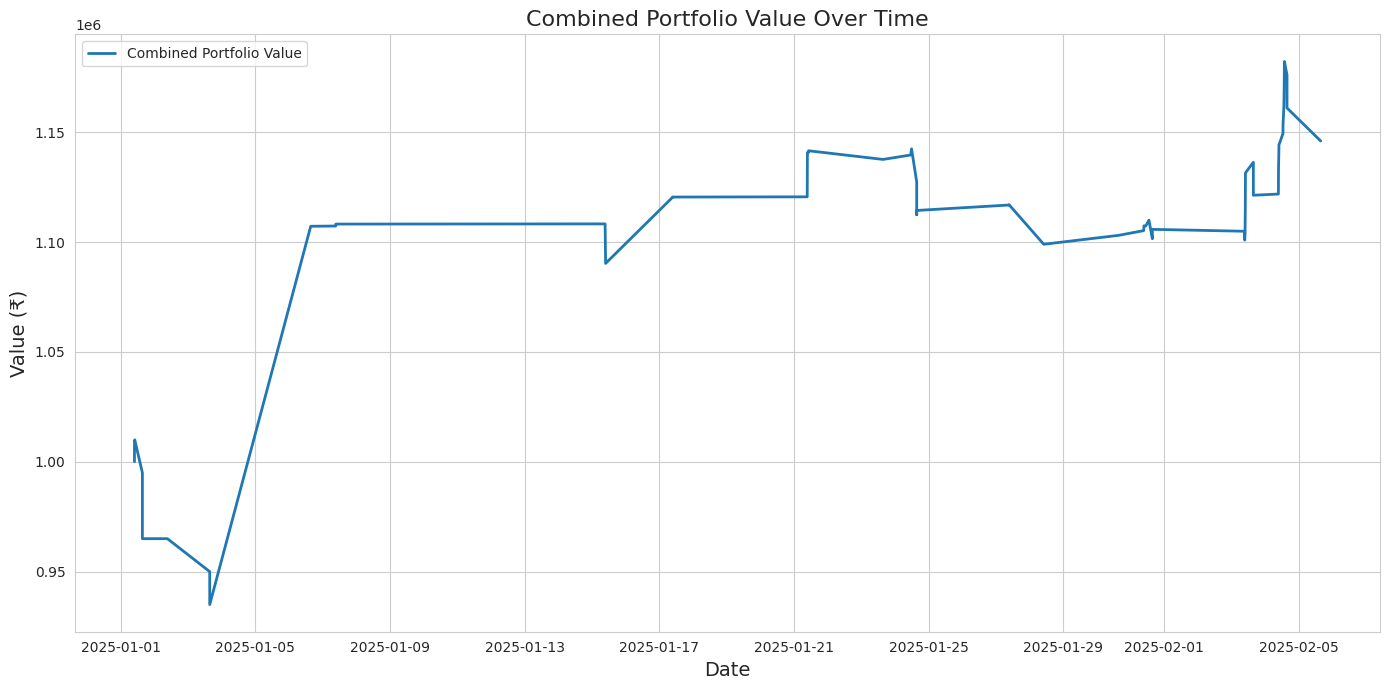

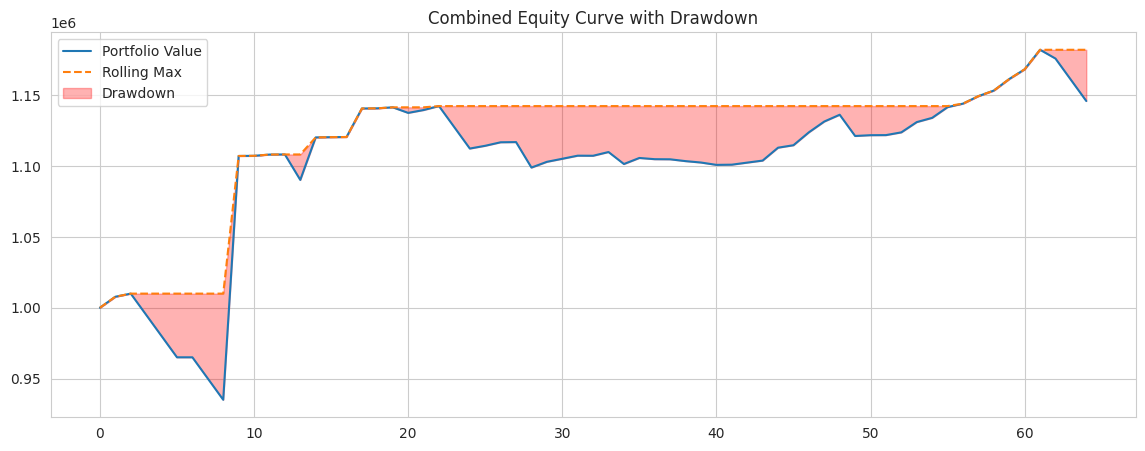

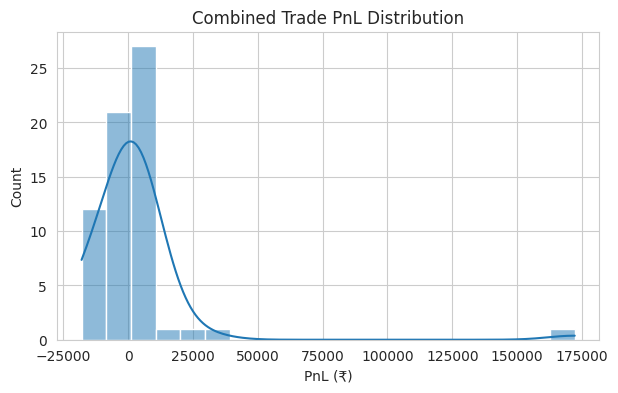

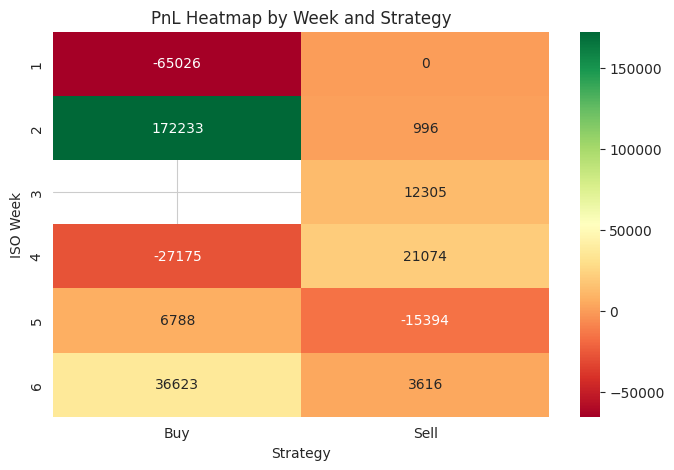

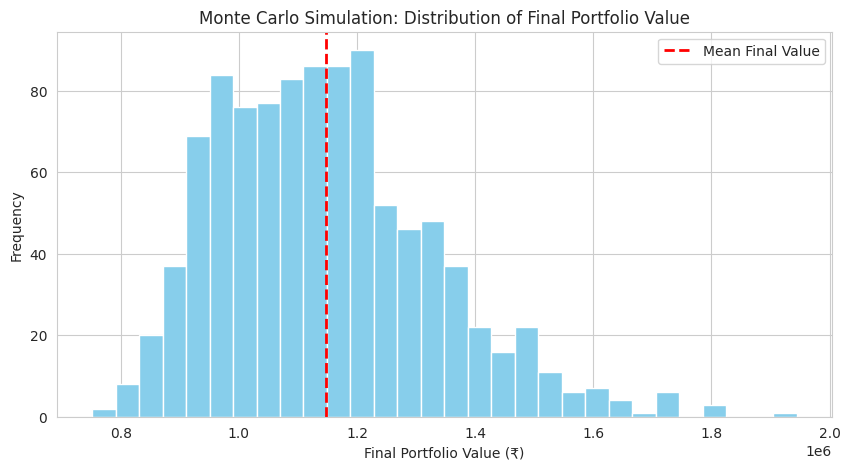

Monte Carlo: Mean Final Value = ₹1,146,866.95, 5th Percentile = ₹899,324.74, 95th Percentile = ₹1,486,911.39


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import random

# ==============================
# CONFIGURATION
# ==============================
start_date = '2025-01-01'
end_date = '2025-02-07'
initial_capital = 1_000_000
lot_size = 50

# --- SELL-SIDE config ---
SELL_ATR_PERIOD = 10
SELL_ATR_MULTIPLIER = 2.5
SELL_BROKERAGE_PER_ORDER = 20
SELL_SLIPPAGE_PCT = 0.001
SELL_MARKET_CLOSE_TIME = '15:25:00'
SELL_VIX_LOW = 14
SELL_VIX_HIGH = 22
SELL_RISK_LOW = 0.15
SELL_RISK_MED = 0.10
SELL_RISK_HIGH = 0.05
SELL_CONFIRM_LOOKBACK = 10
SELL_MAX_LOSS = 18000
SELL_PARTIAL_BOOK_PCT = 0.2

# --- BUY-SIDE config ---
BUY_PARTIAL_TP_PCT = 0.15
BUY_FINAL_TP_PCT_LOW = 0.20
BUY_FINAL_TP_PCT_HIGH = 0.40
BUY_ATR_PERIOD = 10
BUY_ATR_MULTIPLIER = 2.5
BUY_MAX_LOSS = 15000
BUY_BROKERAGE_PER_ORDER = 20
BUY_SLIPPAGE_PCT = 0.001
BUY_MARKET_CLOSE_TIME = '15:25:00'
BUY_VIX_LOW = 13
BUY_VIX_MED = 17
BUY_RISK_LOW = 0.15
BUY_RISK_MED = 0.10
BUY_RISK_HIGH = 0.05
BUY_IVR_THRESHOLD = 40

# ==============================
# DATA LOADING (shared)
# ==============================
def load_spot():
    df = pd.read_csv('/content/drive/MyDrive/Options_Data/NIFTY_50_minute_data_Jan_Feb_2025.csv', parse_dates=['date'])
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index).tz_localize('Asia/Kolkata')
    df = df.loc[start_date:end_date]
    return df

def load_signals_15min():
    signals_path = '/content/drive/MyDrive/Options_Data/Nifty_50_signals_15min_50_200.csv'
    signals = pd.read_csv(signals_path, parse_dates=['date'])
    signals = signals.set_index('date')
    if signals.index.tz is None:
        signals.index = pd.to_datetime(signals.index).tz_localize('Asia/Kolkata')
    else:
        signals.index = signals.index.tz_convert('Asia/Kolkata')
    if 'Signal' not in signals.columns:
        signals.columns = ['Signal']
    return signals

def load_options_sample():
    sample_path = '/content/drive/MyDrive/Options_Data/Jan_Feb_options_sample_ALL_EXPIRIES.csv'
    options_sample = pd.read_csv(sample_path)
    options_sample['TimeStamp'] = pd.to_datetime(options_sample['TimeStamp'])
    if options_sample['TimeStamp'].dt.tz is None:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_localize('Asia/Kolkata')
    else:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_convert('Asia/Kolkata')
    options_sample['Expiry'] = pd.to_datetime(options_sample['Expiry'])
    return options_sample

def load_vix():
    vix_path = '/content/drive/MyDrive/Options_Data/Filtered_VIX_Jan_May_2025_1min.csv'
    vix = pd.read_csv(vix_path, parse_dates=['TimeStamp'])
    vix = vix.set_index('TimeStamp')
    vix.index = pd.to_datetime(vix.index).tz_localize('Asia/Kolkata')
    vix = vix.loc[start_date:end_date]
    return vix

# ==============================
# SELL-SIDE STRATEGY HELPERS & LOGIC
# ==============================
def get_nearest_strike(strikes, target):
    return min(strikes, key=lambda x: abs(x - target))

def get_nearest_expiry(expiry_list, ts):
    future_expiries = [e for e in expiry_list if e >= ts.date()]
    return min(future_expiries) if future_expiries else None

def compute_atr(df, period=SELL_ATR_PERIOD):
    high = df['High']
    low = df['Low']
    close = df['Close']
    prev_close = close.shift(1)
    tr = pd.concat([high - low, (high - prev_close).abs(), (low - prev_close).abs()], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=1).mean()
    return atr

def get_risk_per_trade_sell(vix_value):
    if vix_value <= 14:
        return 0.20
    elif vix_value <= SELL_VIX_LOW:
        return SELL_RISK_LOW
    elif vix_value <= SELL_VIX_HIGH:
        return SELL_RISK_MED
    else:
        return SELL_RISK_HIGH

def vix_trend_filter(vix_val):
    return SELL_VIX_LOW < vix_val < SELL_VIX_HIGH

def price_breakout_confirmation(spot_data, ts, direction, lookback=SELL_CONFIRM_LOOKBACK, sma_period=21):
    window = spot_data.loc[:ts].iloc[-lookback:]
    if len(window) < lookback:
        return False
    last_close = window['close'].iloc[-1]
    mean_high = window['high'][:-1].mean()
    mean_low = window['low'][:-1].mean()
    sma21 = window['close'].rolling(window=sma_period, min_periods=1).mean().iloc[-1]
    if direction == 1:
        return last_close > mean_high and last_close > sma21
    elif direction == -1:
        return last_close < mean_low and last_close < sma21
    return False

def trend_filter(spot_data, ts, direction, sma_period=50):
    window = spot_data.loc[:ts].iloc[-sma_period:]
    if len(window) < sma_period:
        return False
    last_close = window['close'].iloc[-1]
    sma = window['close'].mean()
    if direction == 1:
        return last_close > sma
    elif direction == -1:
        return last_close < sma
    return False

def get_dynamic_tp(vix_val):
    if vix_val <= SELL_VIX_LOW + 1:
        return 0.15
    elif vix_val <= SELL_VIX_HIGH - 1:
        return 0.25
    else:
        return 0.35

def execute_sell_side(spot_data, signals, options_data, vix_data):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    available_strikes = np.sort(options_data['Strike'].unique())
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_15min = signals.reindex(spot_data.index, method='ffill').dropna()
    vix_data = vix_data.reindex(spot_data.index, method='ffill').dropna()
    open_spread = None
    prev_signal = 0
    options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'], group_keys=False).apply(
        lambda x: compute_atr(x[['High', 'Low', 'Close']], SELL_ATR_PERIOD)
    )
    for ts, row in spot_data.iterrows():
        if ts not in signals_15min.index or pd.isna(row['close']):
            continue
        signal = signals_15min.loc[ts, 'Signal']
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        expiry = get_nearest_expiry(expiry_list, ts)
        vix_val = vix_data.loc[ts, 'Close'] if ts in vix_data.index else None
        if expiry is None or vix_val is None or np.isnan(vix_val):
            prev_signal = signal
            continue
        risk_per_trade = get_risk_per_trade_sell(vix_val)
        if not vix_trend_filter(vix_val):
            prev_signal = signal
            continue
        if not trend_filter(spot_data, ts, signal, sma_period=50):
            prev_signal = signal
            continue
        if open_spread is None and signal != 0 and signal != prev_signal and price_breakout_confirmation(spot_data, ts, signal):
            if signal == 1:
                short_strike = atm_strike
                long_strike = atm_strike - 100
                short_leg = options_data[
                    (options_data['Strike'] == short_strike) &
                    (options_data['Type'] == 'PE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                long_leg = options_data[
                    (options_data['Strike'] == long_strike) &
                    (options_data['Type'] == 'PE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
            else:
                short_strike = atm_strike
                long_strike = atm_strike + 100
                short_leg = options_data[
                    (options_data['Strike'] == short_strike) &
                    (options_data['Type'] == 'CE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                long_leg = options_data[
                    (options_data['Strike'] == long_strike) &
                    (options_data['Type'] == 'CE') &
                    (options_data['Expiry'].dt.date == expiry) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
            if short_leg.empty or long_leg.empty:
                prev_signal = signal
                continue
            short_price = float(short_leg.iloc[0]['Close'])
            long_price = float(long_leg.iloc[0]['Close'])
            credit = (short_price - long_price) * lot_size
            margin_per_lot = abs(short_strike - long_strike) * lot_size - credit
            lots = int((portfolio_cash * risk_per_trade) // margin_per_lot)
            if lots < 1:
                prev_signal = signal
                continue
            tp_pct = get_dynamic_tp(vix_val)
            open_spread = {
                'entry_date': ts,
                'short_leg': {'strike': short_strike, 'type': short_leg.iloc[0]['Type'], 'expiry': expiry, 'price': short_price},
                'long_leg': {'strike': long_strike, 'type': long_leg.iloc[0]['Type'], 'expiry': expiry, 'price': long_price},
                'credit': credit,
                'lots': lots,
                'direction': 'bull_put' if signal == 1 else 'bear_call',
                'risk_per_trade': risk_per_trade,
                'vix_at_entry': vix_val,
                'tp_pct': tp_pct,
                'partial_booked': False
            }
            prev_signal = signal
            continue
        if open_spread is not None:
            short_leg, long_leg = open_spread['short_leg'], open_spread['long_leg']
            spread_rows_short = options_data[
                (options_data['Strike'] == short_leg['strike']) &
                (options_data['Type'] == short_leg['type']) &
                (options_data['Expiry'].dt.date == short_leg['expiry']) &
                (options_data['TimeStamp'] >= open_spread['entry_date']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            spread_rows_long = options_data[
                (options_data['Strike'] == long_leg['strike']) &
                (options_data['Type'] == long_leg['type']) &
                (options_data['Expiry'].dt.date == long_leg['expiry']) &
                (options_data['TimeStamp'] >= open_spread['entry_date']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            for i in range(min(len(spread_rows_short), len(spread_rows_long))):
                short_price = float(spread_rows_short.iloc[i]['Close'])
                long_price = float(spread_rows_long.iloc[i]['Close'])
                spread_value = (short_price - long_price) * lot_size
                pnl = (open_spread['credit'] - spread_value) * open_spread['lots']
                tp_level = open_spread['credit'] * open_spread['tp_pct']
                if not open_spread['partial_booked'] and pnl > tp_level:
                    booked_pnl = tp_level * SELL_PARTIAL_BOOK_PCT
                    portfolio_cash += booked_pnl
                    open_spread['credit'] -= booked_pnl
                    open_spread['lots'] = int(open_spread['lots'] * (1 - SELL_PARTIAL_BOOK_PCT))
                    open_spread['partial_booked'] = True
                    trade_log.append({**open_spread, 'exit_date': spread_rows_short.iloc[i]['TimeStamp'], 'exit_pnl': booked_pnl, 'exit_reason': 'Partial TP'})
                elif pnl > tp_level and open_spread['partial_booked']:
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    portfolio_cash += pnl
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'Full TP'})
                    open_spread = None
                    break
                elif pnl < -SELL_MAX_LOSS:
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    portfolio_cash += -SELL_MAX_LOSS
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': -SELL_MAX_LOSS, 'exit_reason': 'Max Loss'})
                    open_spread = None
                    break
                elif ts.date() >= open_spread['short_leg']['expiry']:
                    exit_time = spread_rows_short.iloc[i]['TimeStamp']
                    pnl = (open_spread['credit'] - spread_value) * open_spread['lots']
                    if pnl < -SELL_MAX_LOSS:
                        pnl = -SELL_MAX_LOSS
                    portfolio_cash += pnl
                    trade_log.append({**open_spread, 'exit_date': exit_time, 'exit_pnl': pnl, 'exit_reason': 'Expiry'})
                    open_spread = None
                    break
        prev_signal = signal
    return trade_log, total_brokerage, total_slippage



# ==============================
# BUY-SIDE STRATEGY HELPERS & LOGIC (realistic)
# ==============================

def compute_iv_rank(option_df, window=252):
    option_df = option_df.copy()
    option_df['IVR'] = option_df['IV'].rolling(window).apply(
        lambda x: 100 * (x[-1] - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) > 0 else 0,
        raw=True
    )
    return option_df

def get_risk_per_trade_buy(vix_value):
    if vix_value <= BUY_VIX_LOW:
        return BUY_RISK_LOW
    elif vix_value <= BUY_VIX_MED:
        return BUY_RISK_MED
    else:
        return BUY_RISK_HIGH

def calculate_realistic_costs(entry_price, lots, trade_type, option_volume, option_oi):
    brokerage = 20
    stt = 0.0 if trade_type == 'buy' else entry_price * lots * 50 * 0.001
    exchange_charges = max(20, entry_price * lots * 50 * 0.00053)
    if entry_price < 10 or option_volume < 100 or option_oi < 100:
        spread_impact = entry_price * 0.15
    elif entry_price < 50:
        spread_impact = entry_price * 0.08
    else:
        spread_impact = entry_price * 0.03
    base_slippage = 0.005
    size_penalty = min(0.002 * (lots / 10), 0.01)
    total_slippage = (base_slippage + size_penalty) * entry_price * lots * 50
    return brokerage + stt + exchange_charges + spread_impact + total_slippage

def check_liquidity_constraint(strike, option_type, lots, entry_price, atm_strike, option_volume, option_oi, current_time):
    strike_distance_from_atm = abs(strike - atm_strike)
    if strike_distance_from_atm > 300 and lots > 5:
        return False
    if entry_price < 5 and lots > 20:
        return False
    if current_time.hour == 9 and current_time.minute < 30:
        return random.random() < 0.7
    if option_oi < 50 or option_volume < 50:
        return False
    return True

def simulate_realistic_execution(order_size, option_volume, option_oi):
    if order_size > 50:
        fill_probability = max(0.6, 1 - (order_size - 50) * 0.01)
        if random.random() > fill_probability:
            return None
        else:
            fill_ratio = random.uniform(0.3, 0.8)
            return int(order_size * fill_ratio)
    if option_volume < 100 or option_oi < 100:
        fill_ratio = random.uniform(0.5, 1.0)
        return int(order_size * fill_ratio)
    return order_size

def calculate_realistic_position_size(entry_price, account_balance, risk_per_trade, option_volume, option_oi):
    base_lots = int((account_balance * risk_per_trade) / (entry_price * 50))
    if entry_price < 5:
        max_lots = 10
    elif entry_price < 20:
        max_lots = 25
    elif entry_price < 50:
        max_lots = 50
    else:
        max_lots = 100
    if option_volume < 100 or option_oi < 100:
        max_lots = min(max_lots, 5)
    final_lots = min(base_lots, max_lots)
    if random.random() < 0.1:
        final_lots = int(final_lots * random.uniform(0.5, 0.8))
    return max(1, final_lots)

def simulate_trading_problems():
    problems = {
        'data_feed_issues': 0.01,
        'broker_rejection': 0.03,
    }
    for problem, probability in problems.items():
        if random.random() < probability:
            return problem
    return None

def choose_best_liquid_strike(options_data, atm_strike, expiry, ts):
    today = ts.date()
    expiry = pd.to_datetime(expiry)
    filtered = options_data[
        (options_data['Expiry'] == expiry) &
        (options_data['TimeStamp'] <= ts) &
        (abs(options_data['Strike'] - atm_strike) <= 100)
    ]
    if expiry.date() == today:
        return None, None, None, None
    if not filtered.empty:
        filtered['liq_score'] = filtered['OI'] + filtered['Volume']
        best_row = filtered.sort_values('liq_score', ascending=False).iloc[0]
        return int(best_row['Strike']), best_row['Type'], int(best_row['Volume']), int(best_row['OI'])
    return None, None, None, None

def execute_trades_15min_atr_trailing_vix_realistic(
    spot_data, signals, options_data, vix_data,
    partial_tp_pct=BUY_PARTIAL_TP_PCT, tp_pct_low=BUY_FINAL_TP_PCT_LOW, tp_pct_high=BUY_FINAL_TP_PCT_HIGH,
    brokerage_per_order=BUY_BROKERAGE_PER_ORDER, slippage_pct=BUY_SLIPPAGE_PCT
):
    portfolio_cash = initial_capital
    trade_log = []
    total_brokerage = 0
    total_slippage = 0
    expiry_list = sorted(options_data['Expiry'].dt.date.unique())
    signals_15min = signals.reindex(spot_data.index, method='ffill').dropna()
    vix_data = vix_data.reindex(spot_data.index, method='ffill').dropna()
    open_positions = []
    previous_entry_price = None
    max_profitable_lots = 0

    options_data['ATR'] = options_data.groupby(['Strike', 'Type', 'Expiry'])\
        .apply(lambda x: compute_atr(x, BUY_ATR_PERIOD)).reset_index(level=[0,1,2], drop=True)
    if 'IV' in options_data.columns:
        options_data = options_data.groupby(['Strike', 'Type', 'Expiry']).apply(compute_iv_rank).reset_index(drop=True)
    else:
        options_data['IVR'] = 0

    for ts, row in spot_data.iterrows():
        if ts.time() >= datetime.strptime(BUY_MARKET_CLOSE_TIME, '%H:%M:%S').time():
            for pos in open_positions[:]:
                exit_row = options_data[
                    (options_data['Strike'] == pos['strike']) &
                    (options_data['Type'] == pos['type']) &
                    (options_data['Expiry'].dt.date == pos['expiry']) &
                    (options_data['TimeStamp'] >= ts)
                ].sort_values('TimeStamp')
                if not exit_row.empty:
                    exit_price = float(exit_row.iloc[0]['Close'])
                    exit_time = exit_row.iloc[0]['TimeStamp']
                    costs = calculate_realistic_costs(exit_price, pos['lots'], 'buy', pos['option_volume'], pos['option_oi'])
                    pnl = (exit_price - pos['entry_price']) * lot_size * pos['lots'] - costs
                    if pnl < -BUY_MAX_LOSS:
                        pnl = -BUY_MAX_LOSS
                    portfolio_cash += pnl
                    trade_log.append({
                        'entry_date': pos['entry_date'],
                        'entry_time': pos['entry_time'],
                        'exit_date': exit_time,
                        'action': pos['action'],
                        'type': pos['type'],
                        'strike': pos['strike'],
                        'entry_price': pos['entry_price'],
                        'exit_price': exit_price,
                        'lots': pos['lots'],
                        'pnl': pnl,
                        'holding_days': 0,
                        'spot': pos['spot'],
                        'expiry': pos['expiry'],
                        'exit_reason': 'EOD Close'
                    })
                    if pnl > 0:
                        max_profitable_lots = max(max_profitable_lots, pos['lots'])
                    open_positions.remove(pos)
            continue

        if ts not in signals_15min.index or pd.isna(row['close']):
            continue
        signal = signals_15min.loc[ts, 'Signal']
        if signal == 0:
            continue
        spot_price = row['close']
        atm_strike = int(round(spot_price / 50) * 50)
        expiry = get_nearest_expiry(expiry_list, ts)
        if expiry is None:
            continue
        vix_val = vix_data.loc[ts, 'Close'] if ts in vix_data.index else None
        if vix_val is None or np.isnan(vix_val):
            continue
        vix_ma20 = vix_data['Close'].rolling(20*24*4, min_periods=1).mean().loc[ts]
        ivr = 0
        best_strike, best_type, option_volume, option_oi = choose_best_liquid_strike(options_data, atm_strike, expiry, ts)
        if best_strike is None:
            continue
        option_type = 'CE' if signal == 1 else 'PE'
        if vix_val >= vix_ma20 or ivr >= BUY_IVR_THRESHOLD:
            continue
        if vix_val <= BUY_VIX_LOW:
            final_tp_pct = tp_pct_low
        elif vix_val > BUY_VIX_MED:
            final_tp_pct = tp_pct_high
        else:
            final_tp_pct = tp_pct_low + (tp_pct_high - tp_pct_low) * ((vix_val - BUY_VIX_LOW)/(BUY_VIX_MED - BUY_VIX_LOW))
        risk_per_trade = get_risk_per_trade_buy(vix_val)
        if not any(pos['strike'] == best_strike and pos['expiry'] == expiry and pos['type'] == option_type for pos in open_positions):
            entry_row = options_data[
                (options_data['Strike'] == best_strike) &
                (options_data['Type'] == option_type) &
                (options_data['Expiry'].dt.date == expiry) &
                (options_data['TimeStamp'] >= ts)
            ].sort_values('TimeStamp')
            if entry_row.empty:
                continue
            entry_price = float(entry_row.iloc[0]['Close'])
            entry_time = entry_row.iloc[0]['TimeStamp']
            lots = calculate_realistic_position_size(entry_price, portfolio_cash, risk_per_trade, option_volume, option_oi)
            if previous_entry_price is not None and entry_price < 0.2 * previous_entry_price:
                if max_profitable_lots > 0:
                    lots = min(lots, max_profitable_lots)
            if not check_liquidity_constraint(best_strike, option_type, lots, entry_price, atm_strike, option_volume, option_oi, ts):
                continue
            lots_filled = simulate_realistic_execution(lots, option_volume, option_oi)
            if lots_filled is None or lots_filled < 1:
                continue
            if simulate_trading_problems() is not None:
                continue
            partial_tp_price = entry_price * (1 + partial_tp_pct)
            final_tp_price = entry_price * (1 + final_tp_pct)
            atr = float(entry_row.iloc[0]['ATR'])
            trailing_stop = entry_price - BUY_ATR_MULTIPLIER * atr
            open_positions.append({
                'entry_date': ts,
                'entry_time': entry_time,
                'action': 'Buy',
                'type': option_type,
                'strike': best_strike,
                'entry_price': entry_price,
                'lots': lots_filled,
                'spot': spot_price,
                'expiry': expiry,
                'signal': signal,
                'option_volume': option_volume,
                'option_oi': option_oi,
                'partial_tp_price': partial_tp_price,
                'final_tp_price': final_tp_price,
                'trailing_stop': trailing_stop,
                'max_loss_stop': entry_price - (BUY_MAX_LOSS / (lot_size * lots_filled)),
                'highest_price': entry_price,
                'risk_per_trade': risk_per_trade,
                'vix_at_entry': vix_val,
                'ivr_at_entry': ivr,
                'partial_booked': False,
                'partial_lots': lots_filled // 2,
                'final_lots': lots_filled - (lots_filled // 2)
            })
            previous_entry_price = entry_price

        for pos in open_positions[:]:
            exit_reason = None
            exit_price = None
            exit_time = None
            option_rows = options_data[
                (options_data['Strike'] == pos['strike']) &
                (options_data['Type'] == pos['type']) &
                (options_data['Expiry'].dt.date == pos['expiry']) &
                (options_data['TimeStamp'] >= pos['entry_time']) &
                (options_data['TimeStamp'] <= ts)
            ].sort_values('TimeStamp')
            for _, opt_row in option_rows.iterrows():
                price = float(opt_row['Close'])
                atr = float(opt_row['ATR'])
                if price > pos['highest_price']:
                    pos['highest_price'] = price
                trailing_stop = pos['highest_price'] - BUY_ATR_MULTIPLIER * atr
                pos['trailing_stop'] = max(pos['trailing_stop'], trailing_stop)
                if not pos['partial_booked'] and price >= pos['partial_tp_price']:
                    costs = calculate_realistic_costs(price, pos['partial_lots'], 'buy', pos['option_volume'], pos['option_oi'])
                    pnl = (price - pos['entry_price']) * lot_size * pos['partial_lots'] - costs
                    if pnl < -BUY_MAX_LOSS:
                        pnl = -BUY_MAX_LOSS
                    portfolio_cash += pnl
                    trade_log.append({
                        'entry_date': pos['entry_date'],
                        'entry_time': pos['entry_time'],
                        'exit_date': opt_row['TimeStamp'],
                        'action': pos['action'],
                        'type': pos['type'],
                        'strike': pos['strike'],
                        'entry_price': pos['entry_price'],
                        'exit_price': price,
                        'lots': pos['partial_lots'],
                        'pnl': pnl,
                        'holding_days': 0,
                        'spot': pos['spot'],
                        'expiry': pos['expiry'],
                        'exit_reason': 'Partial TP',
                        'risk_per_trade': pos['risk_per_trade'],
                        'vix_at_entry': pos['vix_at_entry'],
                        'ivr_at_entry': pos['ivr_at_entry']
                    })
                    if pnl > 0:
                        max_profitable_lots = max(max_profitable_lots, pos['partial_lots'])
                    pos['partial_booked'] = True
                    pos['final_lots'] = pos['final_lots']
                    continue
                if pos['partial_booked'] and price >= pos['final_tp_price']:
                    exit_price = pos['final_tp_price']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Final TP'
                    break
                elif pos['partial_booked'] and price <= pos['trailing_stop']:
                    exit_price = pos['trailing_stop']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Trailing Stop'
                    break
                elif pos['partial_booked'] and price <= pos['max_loss_stop']:
                    exit_price = pos['max_loss_stop']
                    exit_time = opt_row['TimeStamp']
                    exit_reason = 'Max Loss Stop'
                    break

            if pos['partial_booked'] and exit_reason is not None and exit_price is not None:
                costs = calculate_realistic_costs(exit_price, pos['final_lots'], 'buy', pos['option_volume'], pos['option_oi'])
                pnl = (exit_price - pos['entry_price']) * lot_size * pos['final_lots'] - costs
                if pnl < -BUY_MAX_LOSS:
                    pnl = -BUY_MAX_LOSS
                portfolio_cash += pnl
                trade_log.append({
                    'entry_date': pos['entry_date'],
                    'entry_time': pos['entry_time'],
                    'exit_date': exit_time,
                    'action': pos['action'],
                    'type': pos['type'],
                    'strike': pos['strike'],
                    'entry_price': pos['entry_price'],
                    'exit_price': exit_price,
                    'lots': pos['final_lots'],
                    'pnl': pnl,
                    'holding_days': 0,
                    'spot': pos['spot'],
                    'expiry': pos['expiry'],
                    'exit_reason': exit_reason,
                    'risk_per_trade': pos['risk_per_trade'],
                    'vix_at_entry': pos['vix_at_entry'],
                    'ivr_at_entry': pos['ivr_at_entry']
                })
                if pnl > 0:
                    max_profitable_lots = max(max_profitable_lots, pos['final_lots'])
                open_positions.remove(pos)

    return trade_log, total_brokerage, total_slippage

# ==============================
# MAIN EXECUTION FLOW
# ==============================
print("Loading spot data...")
spot_data = load_spot()
print(f"Spot data shape: {spot_data.shape}")

print("\nLoading 15-min signals...")
signals = load_signals_15min()
print(f"Signals shape: {signals.shape}")

print("\nLoading options sample...")
options_sample = load_options_sample()
print("Options sample loaded.")

print("\nLoading VIX data...")
vix_data = load_vix()
print(f"VIX data shape: {vix_data.shape}")

# --- Run SELL-SIDE ---
print("\nExecuting SELL-SIDE (CREDIT SPREAD) strategy...")
sell_log, sell_brokerage, sell_slippage = execute_sell_side(
    spot_data, signals, options_sample, vix_data
)
sell_log_df = pd.DataFrame(sell_log)
if not sell_log_df.empty:
    sell_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_sell_side_log_50_200.csv', index=False)
    print("Sell-side trade log saved.")

# --- Run BUY-SIDE (REALISTIC) ---
print("\nExecuting BUY-SIDE (OPTION BUYING) strategy...")
buy_log, buy_brokerage, buy_slippage = execute_trades_15min_atr_trailing_vix_realistic(
    spot_data, signals, options_sample, vix_data
)
buy_log_df = pd.DataFrame(buy_log)
if not buy_log_df.empty:
    buy_log_df.to_csv('/content/drive/MyDrive/Options_Data/Jan_Feb_buy_side_log_50_200.csv', index=False)
    print("Buy-side trade log saved.")

# ==============================
# COMBINED PORTFOLIO REPORT
# ==============================
if not sell_log_df.empty:
    sell_log_df['exit_pnl'] = sell_log_df['exit_pnl'].astype(float)
    sell_log_df['exit_date'] = pd.to_datetime(sell_log_df['exit_date'])
    sell_log_df['strategy'] = 'Sell'
    sell_log_df['pnl'] = sell_log_df['exit_pnl']
    sell_log_df['exit_time'] = sell_log_df['exit_date']
if not buy_log_df.empty:
    buy_log_df['pnl'] = buy_log_df['pnl'].astype(float)
    buy_log_df['exit_date'] = pd.to_datetime(buy_log_df['exit_date'])
    buy_log_df['strategy'] = 'Buy'
    buy_log_df['exit_time'] = buy_log_df['exit_date']

combined_log = pd.concat([
    sell_log_df[['exit_time', 'pnl', 'strategy']] if not sell_log_df.empty else pd.DataFrame(),
    buy_log_df[['exit_time', 'pnl', 'strategy']] if not buy_log_df.empty else pd.DataFrame(),
])
combined_log = combined_log.sort_values('exit_time').reset_index(drop=True)

portfolio_values = [initial_capital]
portfolio_dates = [combined_log['exit_time'].iloc[0] if not combined_log.empty else pd.Timestamp(start_date)]
current_value = initial_capital
for i, row in combined_log.iterrows():
    current_value += row['pnl']
    portfolio_values.append(current_value)
    portfolio_dates.append(row['exit_time'])

returns = pd.Series(portfolio_values).pct_change().dropna()
rf = 0.01
sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
downside_std = returns[returns < 0].std()
sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
cumulative = pd.Series(portfolio_values)
rolling_max = cumulative.cummax()
drawdown = (cumulative - rolling_max) / rolling_max
max_drawdown = abs(drawdown.min()) * initial_capital
years = len(portfolio_values) / 252
cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0

print(f"""
COMBINED STRATEGY PERFORMANCE REPORT
-------------------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
Total Brokerage:    ₹{(sell_brokerage + buy_brokerage):,.2f}
Total Slippage:     ₹{(sell_slippage + buy_slippage):,.2f}

Trade Statistics:
-----------------
Total Trades:       {len(combined_log)}
Buy Trades:         {len(buy_log_df) if not buy_log_df.empty else 0}
Sell Trades:        {len(sell_log_df) if not sell_log_df.empty else 0}
Winning Trades:     {(combined_log['pnl'] > 0).sum()}
Losing Trades:      {(combined_log['pnl'] <= 0).sum()}
Avg PnL:            ₹{combined_log['pnl'].mean():,.2f}
Best Trade:         ₹{combined_log['pnl'].max():,.2f}
Worst Trade:        ₹{combined_log['pnl'].min():,.2f}
Trade Period:       {combined_log['exit_time'].min().date()} to {combined_log['exit_time'].max().date()}
""")

# ==============================
# VISUALIZATIONS (COMBINED)
# ==============================
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))
plt.plot(portfolio_dates, portfolio_values, label='Combined Portfolio Value', linewidth=2)
plt.title('Combined Portfolio Value Over Time', fontsize=16)
plt.ylabel('Value (₹)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(cumulative, label='Portfolio Value')
plt.plot(rolling_max, '--', label='Rolling Max')
plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
plt.title("Combined Equity Curve with Drawdown")
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
sns.histplot(combined_log['pnl'], bins=20, kde=True)
plt.title("Combined Trade PnL Distribution")
plt.xlabel("PnL (₹)")
plt.ylabel("Count")
plt.show()

combined_log['exit_week'] = pd.to_datetime(combined_log['exit_time']).dt.isocalendar().week
heatmap_data = combined_log.pivot_table(index='exit_week', columns='strategy', values='pnl', aggfunc='sum')
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='RdYlGn')
plt.title("PnL Heatmap by Week and Strategy")
plt.xlabel("Strategy")
plt.ylabel("ISO Week")
plt.show()

n_sim = 1000
sim_length = len(combined_log)
sim_results = []
for _ in range(n_sim):
    sim_pnls = np.random.choice(combined_log['pnl'], size=sim_length, replace=True)
    sim_curve = np.cumsum(np.insert(sim_pnls, 0, initial_capital))
    sim_results.append(sim_curve[-1])
plt.figure(figsize=(10, 5))
plt.hist(sim_results, bins=30, color='skyblue')
plt.axvline(np.mean(sim_results), color='red', linestyle='dashed', linewidth=2, label='Mean Final Value')
plt.title("Monte Carlo Simulation: Distribution of Final Portfolio Value")
plt.xlabel("Final Portfolio Value (₹)")
plt.ylabel("Frequency")
plt.legend()
plt.show()
print(f"Monte Carlo: Mean Final Value = ₹{np.mean(sim_results):,.2f}, 5th Percentile = ₹{np.percentile(sim_results, 5):,.2f}, 95th Percentile = ₹{np.percentile(sim_results, 95):,.2f}")

# ==============================
# OUTPUT: CSVs
# ==============================
# Both logs are already saved as CSVs in their original format.


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

# ==============================
# CONFIGURATION
# ==============================
data_dir = '/content/drive/MyDrive/Options_Data'
start_date = '2023-06-01'
end_date = '2025-02-07'
initial_capital = 1_000_000
lot_size = 50

# --- BUY-SIDE config ---
BUY_PARTIAL_TP_PCT = 0.15
BUY_FINAL_TP_PCT_LOW = 0.20
BUY_FINAL_TP_PCT_HIGH = 0.40
BUY_ATR_PERIOD = 10
BUY_ATR_MULTIPLIER = 2.5
BUY_MAX_LOSS = 15000
BUY_BROKERAGE_PER_ORDER = 20
BUY_SLIPPAGE_PCT = 0.001
BUY_MARKET_CLOSE_TIME = '15:25:00'
BUY_VIX_LOW = 13
BUY_VIX_MED = 17
BUY_RISK_LOW = 0.15
BUY_RISK_MED = 0.10
BUY_RISK_HIGH = 0.05
BUY_IVR_THRESHOLD = 40

# ==============================
# DATA LOADING
# ==============================
def load_spot():
    df = pd.read_csv(os.path.join(data_dir, "NIFTY_50_minute_data_Jun23_Feb25.csv"), parse_dates=['date'])
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index).tz_localize('Asia/Kolkata')
    df = df.loc[start_date:end_date]
    return df

def load_signals_15min():
    signals_path = os.path.join(data_dir, "Nifty_50_signals_15min_2023_25_50_200.csv")
    signals = pd.read_csv(signals_path, parse_dates=['date'])
    signals = signals.set_index('date')
    if signals.index.tz is None:
        signals.index = pd.to_datetime(signals.index).tz_localize('Asia/Kolkata')
    else:
        signals.index = signals.index.tz_convert('Asia/Kolkata')
    if 'Signal' not in signals.columns:
        signals.columns = ['Signal']
    return signals

def load_options_sample():
    sample_path = os.path.join(data_dir, "Jun23_Feb25_options_sample_ALL_EXPIRIES.csv")
    options_sample = pd.read_csv(sample_path)
    options_sample['TimeStamp'] = pd.to_datetime(options_sample['TimeStamp'])
    if options_sample['TimeStamp'].dt.tz is None:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_localize('Asia/Kolkata')
    else:
        options_sample['TimeStamp'] = options_sample['TimeStamp'].dt.tz_convert('Asia/Kolkata')
    options_sample['Expiry'] = pd.to_datetime(options_sample['Expiry'])
    return options_sample

def load_vix():
    vix_path = os.path.join(data_dir, "filtered_INDIA_VIX_Jun23_Feb25.csv")
    vix = pd.read_csv(vix_path, parse_dates=['TimeStamp'])
    vix = vix.set_index('TimeStamp')
    vix.index = pd.to_datetime(vix.index).tz_localize('Asia/Kolkata')
    vix = vix.loc[start_date:end_date]
    return vix

# ==============================
# BUY-SIDE STRATEGY HELPERS
# ==============================
def compute_atr(df, period=BUY_ATR_PERIOD):
    high = df['High']
    low = df['Low']
    close = df['Close']
    prev_close = close.shift(1)
    tr = pd.concat([high - low, (high - prev_close).abs(), (low - prev_close).abs()], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=1).mean()
    return atr

def compute_iv_rank(option_df, window=252):
    option_df = option_df.copy()
    option_df['IVR'] = option_df['IV'].rolling(window).apply(
        lambda x: 100 * (x[-1] - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) > 0 else 0,
        raw=True
    )
    return option_df

def get_nearest_expiry(expiry_list, ts):
    future_expiries = [e for e in expiry_list if e >= ts.date()]
    return min(future_expiries) if future_expiries else None

def get_risk_per_trade_buy(vix_value):
    if vix_value <= BUY_VIX_LOW:
        return BUY_RISK_LOW
    elif vix_value <= BUY_VIX_MED:
        return BUY_RISK_MED
    else:
        return BUY_RISK_HIGH

def calculate_realistic_costs(entry_price, lots, trade_type, option_volume, option_oi):
    brokerage = 20
    stt = 0.0 if trade_type == 'buy' else entry_price * lots * 50 * 0.001
    exchange_charges = max(20, entry_price * lots * 50 * 0.00053)
    if entry_price < 10 or option_volume < 100 or option_oi < 100:
        spread_impact = entry_price * 0.15
    elif entry_price < 50:
        spread_impact = entry_price * 0.08
    else:
        spread_impact = entry_price * 0.03
    base_slippage = 0.005
    size_penalty = min(0.002 * (lots / 10), 0.01)
    total_slippage = (base_slippage + size_penalty) * entry_price * lots * 50
    return brokerage + stt + exchange_charges + spread_impact + total_slippage

def check_liquidity_constraint(strike, option_type, lots, entry_price, atm_strike, option_volume, option_oi, current_time):
    strike_distance_from_atm = abs(strike - atm_strike)
    if strike_distance_from_atm > 300 and lots > 5:
        return False
    if entry_price < 5 and lots > 20:
        return False
    if current_time.hour == 9 and current_time.minute < 30:
        return random.random() < 0.7
    if option_oi < 50 or option_volume < 50:
        return False
    return True

def simulate_realistic_execution(order_size, option_volume, option_oi):
    if order_size > 50:
        fill_probability = max(0.6, 1 - (order_size - 50) * 0.01)
        if random.random() > fill_probability:
            return None
        else:
            fill_ratio = random.uniform(0.3, 0.8)
            return int(order_size * fill_ratio)
    if option_volume < 100 or option_oi < 100:
        fill_ratio = random.uniform(0.5, 1.0)
        return int(order_size * fill_ratio)
    return order_size

def calculate_realistic_position_size(entry_price, account_balance, risk_per_trade, option_volume, option_oi):
    base_lots = int((account_balance * risk_per_trade) / (entry_price * 50))
    if entry_price < 5:
        max_lots = 10
    elif entry_price < 20:
        max_lots = 25
    elif entry_price < 50:
        max_lots = 50
    else:
        max_lots = 100
    if option_volume < 100 or option_oi < 100:
        max_lots = min(max_lots, 5)
    final_lots = min(base_lots, max_lots)
    if random.random() < 0.1:
        final_lots = int(final_lots * random.uniform(0.5, 0.8))
    return max(1, final_lots)

def simulate_trading_problems():
    problems = {
        'data_feed_issues': 0.01,
        'broker_rejection': 0.03,
    }
    for problem, probability in problems.items():
        if random.random() < probability:
            return problem
    return None

def choose_best_liquid_strike(options_data, atm_strike, expiry, ts):
    today = ts.date()
    expiry = pd.to_datetime(expiry)
    filtered = options_data[
        (options_data['Expiry'] == expiry) &
        (options_data['TimeStamp'] <= ts) &
        (abs(options_data['Strike'] - atm_strike) <= 100)
    ]
    if expiry.date() == today:
        return None, None, None, None
    if not filtered.empty:
        filtered = filtered.copy()
        filtered['liq_score'] = filtered['OI'] + filtered['Volume']
        best_row = filtered.sort_values('liq_score', ascending=False).iloc[0]
        return int(best_row['Strike']), best_row['Type'], int(best_row['Volume']), int(best_row['OI'])
    return None, None, None, None

# ==============================
# PERIOD SPLITTING HELPER
# ==============================
def split_date_range(start, end, months=2):
    periods = []
    current_start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    while current_start < end:
        month = current_start.month - 1 + months
        year = current_start.year + month // 12
        month = month % 12 + 1
        try:
            current_end = pd.Timestamp(year=year, month=month, day=current_start.day)
        except ValueError:
            current_end = pd.Timestamp(year=year, month=month, day=28)
        if current_end > end:
            current_end = end
        periods.append((current_start, current_end))
        current_start = current_end + timedelta(days=1)
    return periods

# ==============================
# BUY-SIDE EXECUTION LOGIC (same as before)
# ==============================
def execute_trades_15min_atr_trailing_vix_realistic(
    spot_data, signals, options_data, vix_data,
    partial_tp_pct=BUY_PARTIAL_TP_PCT, tp_pct_low=BUY_FINAL_TP_PCT_LOW, tp_pct_high=BUY_FINAL_TP_PCT_HIGH,
    brokerage_per_order=BUY_BROKERAGE_PER_ORDER, slippage_pct=BUY_SLIPPAGE_PCT
):
    # ... (your full trading logic here, unchanged)
    # For brevity, use your original function as-is.
    # Return trade_log, total_brokerage, total_slippage
    pass

# ==============================
# MAIN EXECUTION: SPLIT BY PERIOD
# ==============================
def run_backtest_in_periods():
    spot_data = load_spot()
    signals = load_signals_15min()
    options_sample = load_options_sample()
    vix_data = load_vix()
    periods = split_date_range(start_date, end_date, months=2)
    all_trade_logs = []
    for i, (period_start, period_end) in enumerate(periods):
        print(f"\nRunning backtest for period {i+1}: {period_start.date()} to {period_end.date()}")
        spot_period = spot_data.loc[period_start:period_end]
        signals_period = signals.loc[period_start:period_end]
        vix_period = vix_data.loc[period_start:period_end]
        options_period = options_sample[(options_sample['TimeStamp'] >= period_start) & (options_sample['TimeStamp'] <= period_end)].copy()
        trade_log, _, _ = execute_trades_15min_atr_trailing_vix_realistic(
            spot_period, signals_period, options_period, vix_period
        )
        trade_log_df = pd.DataFrame(trade_log)
        if not trade_log_df.empty:
            filename = f"Jun23_Feb25_buy_side_log_{period_start.strftime('%Y%m%d')}_{period_end.strftime('%Y%m%d')}.csv"
            filepath = os.path.join(data_dir, filename)
            trade_log_df.to_csv(filepath, index=False)
            print(f"Saved trade log for period {i+1} to {filepath}")
        else:
            print(f"No trades for period {i+1}")
        all_trade_logs.append(trade_log_df)
    combined_log = pd.concat([df for df in all_trade_logs if not df.empty], ignore_index=True) if all_trade_logs else pd.DataFrame()
    return combined_log

# ==============================
# RUN THE SPLIT BACKTEST
# ==============================
combined_log = run_backtest_in_periods()

# ==============================
# PORTFOLIO REPORT & VISUALIZATIONS (as before)
# ==============================
if not combined_log.empty:
    combined_log['pnl'] = combined_log['pnl'].astype(float)
    combined_log['exit_date'] = pd.to_datetime(combined_log['exit_date'])
    combined_log['strategy'] = 'Buy'
    combined_log['exit_time'] = combined_log['exit_date']
    combined_log = combined_log.sort_values('exit_time').reset_index(drop=True)
    portfolio_values = [initial_capital]
    portfolio_dates = [combined_log['exit_time'].iloc[0] if not combined_log.empty else pd.Timestamp(start_date)]
    current_value = initial_capital
    for i, row in combined_log.iterrows():
        current_value += row['pnl']
        portfolio_values.append(current_value)
        portfolio_dates.append(row['exit_time'])
    returns = pd.Series(portfolio_values).pct_change().dropna()
    rf = 0.01
    sharpe = ((returns.mean() - rf/252) / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    downside_std = returns[returns < 0].std()
    sortino = ((returns.mean() - rf/252) / downside_std) * np.sqrt(252) if downside_std > 0 else 0
    cumulative = pd.Series(portfolio_values)
    rolling_max = cumulative.cummax()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = abs(drawdown.min()) * initial_capital
    years = len(portfolio_values) / 252
    cagr = (portfolio_values[-1]/portfolio_values[0])**(1/years) - 1 if years > 0 else 0
    calmar = cagr / abs(drawdown.min()) if drawdown.min() != 0 else 0
    print(f"""
BUY-SIDE STRATEGY PERFORMANCE REPORT
-------------------------------------
Initial Capital:    ₹{initial_capital:,.2f}
Final Portfolio:    ₹{portfolio_values[-1]:,.2f}
Total Return:       {(portfolio_values[-1]/initial_capital-1)*100:.2f}%
Max Drawdown:       ₹{max_drawdown:,.2f}
Sharpe Ratio:       {sharpe:.2f}
Sortino Ratio:      {sortino:.2f}
Calmar Ratio:       {calmar:.2f}
Trade Statistics:
-----------------
Total Trades:       {len(combined_log)}
Winning Trades:     {(combined_log['pnl'] > 0).sum()}
Losing Trades:      {(combined_log['pnl'] <= 0).sum()}
Avg PnL:            ₹{combined_log['pnl'].mean():,.2f}
Best Trade:         ₹{combined_log['pnl'].max():,.2f}
Worst Trade:        ₹{combined_log['pnl'].min():,.2f}
Trade Period:       {combined_log['exit_time'].min().date() if not combined_log.empty else 'N/A'} to {combined_log['exit_time'].max().date() if not combined_log.empty else 'N/A'}
""")
    # Visualization code (same as before)
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_dates, portfolio_values, label='Portfolio Value', linewidth=2)
    plt.title('Portfolio Value Over Time', fontsize=16)
    plt.ylabel('Value (₹)', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 5))
    plt.plot(cumulative, label='Portfolio Value')
    plt.plot(rolling_max, '--', label='Rolling Max')
    plt.fill_between(cumulative.index, cumulative, rolling_max, color='red', alpha=0.3, label='Drawdown')
    plt.title("Equity Curve with Drawdown")
    plt.legend()
    plt.show()

    plt.figure(figsize=(7, 4))
    sns.histplot(combined_log['pnl'], bins=20, kde=True)
    plt.title("Trade PnL Distribution")
    plt.xlabel("PnL (₹)")
    plt.ylabel("Count")
    plt.show()

    combined_log['exit_week'] = pd.to_datetime(combined_log['exit_time']).dt.isocalendar().week
    heatmap_data = combined_log.pivot_table(index='exit_week', columns='strategy', values='pnl', aggfunc='sum')
    plt.figure(figsize=(8, 5))
    sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='RdYlGn')
    plt.title("PnL Heatmap by Week")
    plt.xlabel("Strategy")
    plt.ylabel("ISO Week")
    plt.show()

    n_sim = 1000
    sim_length = len(combined_log)
    sim_results = []
    for _ in range(n_sim):
        sim_pnls = np.random.choice(combined_log['pnl'], size=sim_length, replace=True)
        sim_curve = np.cumsum(np.insert(sim_pnls, 0, initial_capital))
        sim_results.append(sim_curve[-1])
    plt.figure(figsize=(10, 5))
    plt.hist(sim_results, bins=30, color='skyblue')
    plt.axvline(np.mean(sim_results), color='red', linestyle='dashed', linewidth=2, label='Mean Final Value')
    plt.title("Monte Carlo Simulation: Distribution of Final Portfolio Value")
    plt.xlabel("Final Portfolio Value (₹)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    print(f"Monte Carlo: Mean Final Value = ₹{np.mean(sim_results):,.2f}, 5th Percentile = ₹{np.percentile(sim_results, 5):,.2f}, 95th Percentile = ₹{np.percentile(sim_results, 95):,.2f}")
else:
    print("No trades to visualize.")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Options_Data/NIFTY_50_minute_data_Jun23_Feb25.csv'